In [1]:
%%time

from pysme.synthesize import synthesize_spectrum
from pysme.linelist.linelist import LineList
from pysme.linelist.vald import ValdFile
from pysme.sme import SME_Structure
from pysme.util import vac2air
from pysme.solve import solve
from pysme.abund import Abund
from pysme import sme as SME
from pysme import util

from IPython.display import clear_output
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from astropy.constants import c
from scipy.stats import norm
import pandas as pd
import numpy as np

import warnings
import glob
import sys
import os
import gc

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

CPU times: user 2.03 s, sys: 3.45 s, total: 5.49 s
Wall time: 14.8 s


In [2]:
os.chdir('/home/fgran/iSpec/')
import ispec
sys.path.append('/home/fgran/iSpec/')

In [3]:
#Move to the correct directory: Pristine-UVES
os.chdir('/store/teams/cosmos/fgran/data/Pristine-UVES/')

In [4]:
max_threads = 40
os.environ['NUMEXPR_MAX_THREADS'] = '%s' %max_threads #change this number using the correct number of cores/threads in jupyter.slurm

In [5]:
#Prepare catalogue ingestion

In [6]:
uves = pd.read_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_uncs_fe_c_corr_n.csv')

In [7]:
uves.head(2)

,source_id,ebv,g0,eg,bp0,ebp,rp0,erp,cahk0,ecahk,...,n_nh,en_nh_sme,en_nh_fit,niter_n_nh,n_cn,en_cn_sme,en_cn_fit,niter_n_cn,is_limit_n_nh,is_limit_n_cn
0,1166634514845213568,0.034659,11.670373,0.002767,12.097350,0.002867,11.063974,0.003820,13.051166,0.009495,...,8.085670,0.333929,0.016327,18,5.052851,4300.554092,285.064617,1,True,False
1,1172165023972931072,0.026574,12.876005,0.002772,13.314315,0.003091,12.258079,0.003841,14.291629,0.016091,...,8.122671,0.281719,0.014353,15,4.691659,36267.501171,3576.525820,1,True,False


In [8]:
#pysme that only need to be executed once

In [9]:
wmin_blue = 3700 #AA
wmax_blue = 4500 #AA
wmin_red1 = 4730 #AA
wmax_red1 = 5700 #AA
wmin_red2 = 5850 #AA
wmax_red2 = 6800 #AA

In [10]:
linelist = ValdFile('linelist/3800-6800_long.lin')
linelist = linelist[((linelist.wlcent > wmin_blue) & (linelist.wlcent < wmax_blue)) | \
                                         (linelist.wlcent > wmin_red1) & (linelist.wlcent < wmax_red1) | \
                                         (linelist.wlcent > wmin_red2) & (linelist.wlcent < wmax_red2)]

print('Number of lines in the linelist: %d' %linelist.species.size)

#Delta lines definitions
delta_line = 1. #AA
delta_cont = 1.5 #AA
delta_cont_Ca = 25 #AA
delta_wl_limit = 0.05

[2025-06-13 13:26:14,781] [INFO] [vald:loads:174]: Loading VALD file linelist/3800-6800_long.lin


INFO - Loading VALD file linelist/3800-6800_long.lin
Number of lines in the linelist: 2681


In [12]:
%%time

#Only for n-capture elements

linelist = pd.DataFrame(ValdFile('linelist/3800-6800_long.lin'))
linelist = linelist[~linelist.species.str.contains('Sr|Ce|Gd|Hf|Ir|Os|Pb|Pr|Sm|Th|Tm|U|Ba|Dy|Er|Eu|La|Nd|Y|Zr', regex=True, case=True).values] #Remove n-capture transitions from the linelist

wmin_blue = 3800
wmax_blue = 5800

lls_names = ['linelist/Eu_VALD_all.lin', 'linelist/Sr_VALD_all.lin', 'linelist/Ba_VALD_all.lin', 'linelist/Ce_VALD_all.lin', 
       'linelist/Dy_VALD_all.lin', 'linelist/Er_VALD_all.lin', 'linelist/Gd_VALD_all.lin', 'linelist/Hf_VALD_all.lin', 'linelist/Ir_VALD_all.lin',
       'linelist/La_VALD_all.lin', 'linelist/Nd_VALD_all.lin', 'linelist/Os_VALD_all.lin', 'linelist/Pb_VALD_all.lin',
       'linelist/Pr_VALD_all.lin', 
       'linelist/Sm_VALD_all.lin', 'linelist/Th_VALD_all.lin', 'linelist/Tm_VALD_all.lin', 'linelist/U_VALD_all.lin',
       'linelist/Y_VALD_all.lin', 'linelist/Zr_VALD_all.lin']

lls_ions = ['2', '2', '2', '2',
       '2', '2', '2', '2', '1',
       '2', '2', '1', '1',
       '2',
       '2', '2', '2', '2',
       '2', '2']

for ll_name, ll_ion in zip(lls_names, lls_ions):

    print(ll_name, ll_ion)
    ll = pd.DataFrame(ValdFile(ll_name))

    if 'Eu_' in ll_name:
        ll = ll.query('abs(wlcent - 3930.499) < 2.0 or abs(wlcent - 4129.725) < 2.0 or abs(wlcent - 4205.042) < 2.0 or abs(wlcent - 4435.578) < 2.0 or abs(wlcent - 4522.581) < 2.0')
    if 'Sr_' in ll_name:
        ll = ll.query('abs(wlcent - 4077.709) < 2.0 or abs(wlcent - 4161.792) < 2.0 or abs(wlcent - 4215.519) < 2.0')
    if 'Ba_' in ll_name:
        ll = ll.query('abs(wlcent - 3891.776) < 2.0 or abs(wlcent - 4130.645) < 2.0 or abs(wlcent - 4554.029) < 2.0 or abs(wlcent - 4934.076) < 2.0 or abs(wlcent - 5853.668) < 2.0')
    if 'Ce_' in ll_name:
        ll = ll.query('abs(wlcent - 4073.474) < 2.0 or abs(wlcent - 4083.222) < 2.0 or abs(wlcent - 4120.827) < 2.0 or abs(wlcent - 4127.364) < 2.0 or abs(wlcent - 4222.597) < 2.0\
          or abs(wlcent - 4418.780) < 2.0 or abs(wlcent - 4486.909) < 2.0 or abs(wlcent - 4562.359) < 2.0 or abs(wlcent - 4628.161) < 2.0')
    if 'Dy_' in ll_name:
        ll = ll.query('abs(wlcent - 3869.864) < 2.0 or abs(wlcent - 3996.689) < 2.0 or abs(wlcent - 4011.285) < 2.0 or abs(wlcent - 4103.306) < 2.0 or abs(wlcent - 4468.138) < 2.0\
          or abs(wlcent - 5169.688) < 2.0')
    if 'Er_' in ll_name:
        ll = ll.query('abs(wlcent - 3692.649) < 2.0 or abs(wlcent - 3786.836) < 2.0 or abs(wlcent - 3830.482) < 2.0 or abs(wlcent - 3896.234) < 2.0 or abs(wlcent - 3938.626) < 2.0')
    if 'Gd_' in ll_name:
        ll = ll.query('abs(wlcent - 3768.396) < 2.0 or abs(wlcent - 3796.384) < 2.0 or abs(wlcent - 3836.915) < 2.0 or abs(wlcent - 3844.578) < 2.0 or abs(wlcent - 3916.509) < 2.0\
          or abs(wlcent - 4037.893) < 2.0 or abs(wlcent - 4085.558) < 2.0 or abs(wlcent - 4130.366) < 2.0 or abs(wlcent - 4191.075) < 2.0')
    if 'Hf_' in ll_name:
        ll = ll.query('abs(wlcent - 3399.793) < 2.0 or abs(wlcent - 3719.276) < 2.0')
    if 'Ir_' in ll_name:
        ll = ll.query('abs(wlcent - 3800.120) < 2.0')
    if 'La_' in ll_name:
        ll = ll.query('abs(wlcent - 3849.006) < 2.0 or abs(wlcent - 4086.709) < 2.0 or abs(wlcent - 4123.218) < 2.0 or abs(wlcent - 5122.988) < 2.0 or abs(wlcent - 6320.376) < 2.0')
    if 'Nd_' in ll_name:
        ll = ll.query('abs(wlcent - 3973.260) < 2.0 or abs(wlcent - 4018.823) < 2.0 or abs(wlcent - 4021.327) < 2.0 or abs(wlcent - 4061.080) < 2.0 or abs(wlcent - 4069.265) < 2.0\
          or abs(wlcent - 4109.448) < 2.0 or abs(wlcent - 4232.374) < 2.0 or abs(wlcent - 4446.384) < 2.0 or abs(wlcent - 4462.979) < 2.0 or abs(wlcent - 5130.586) < 2.0\
          or abs(wlcent - 5212.361) < 2.0 or abs(wlcent - 5234.194) < 2.0 or abs(wlcent - 5249.576) < 2.0 or abs(wlcent - 5293.163) < 2.0 or abs(wlcent - 5311.453) < 2.0\
          or abs(wlcent - 5319.815) < 2.0 or abs(wlcent - 5361.467) < 2.0 or abs(wlcent - 5442.264) < 2.0')
    if 'Os_' in ll_name:
        ll = ll.query('abs(wlcent - 4135.775) < 2.0 or abs(wlcent - 4260.848) < 2.0 or abs(wlcent - 4420.468) < 2.0')
    if 'Pb_' in ll_name:
        ll = ll.query('abs(wlcent - 4057.807) < 2.0')
    if 'Pr_' in ll_name:
        ll = ll.query('abs(wlcent - 3964.262) < 2.0 or abs(wlcent - 3964.812) < 2.0 or abs(wlcent - 3965.253) < 2.0 or abs(wlcent - 4062.805) < 2.0 or abs(wlcent - 5220.108) < 2.0\
          or abs(wlcent - 5259.728) < 2.0')
    if 'Sm_' in ll_name:
        ll = ll.query('abs(wlcent - 3896.972) < 2.0 or abs(wlcent - 4023.222) < 2.0 or abs(wlcent - 4068.324) < 2.0 or abs(wlcent - 4318.927) < 2.0 or abs(wlcent - 4499.475) < 2.0\
          or abs(wlcent - 4519.630) < 2.0 or abs(wlcent - 4537.941) < 2.0 or abs(wlcent - 4577.688) < 2.0')
    if 'Th_' in ll_name:
        ll = ll.query('abs(wlcent - 4019.129) < 2.0 or abs(wlcent - 4086.521) < 2.0 or abs(wlcent - 4094.747) < 2.0')
    if 'Tm_' in ll_name:
        ll = ll.query('abs(wlcent - 3848.020) < 2.0')
    if 'U_' in ll_name:
        ll = ll.query('abs(wlcent - 3859.571) < 2.0')
    if 'Y_' in ll_name:
        ll = ll.query('abs(wlcent - 3818.341) < 2.0 or abs(wlcent - 3950.352) < 2.0 or abs(wlcent - 4398.013) < 2.0 or abs(wlcent - 4883.684) < 2.0 or abs(wlcent - 5087.416) < 2.0\
          or abs(wlcent - 5123.211) < 2.0 or abs(wlcent - 5200.406) < 2.0 or abs(wlcent - 5205.724) < 2.0')
    if 'Zr_' in ll_name:
        ll = ll.query('abs(wlcent - 3836.762) < 2.0 or abs(wlcent - 4161.213) < 2.0 or abs(wlcent - 4208.977) < 2.0 or abs(wlcent - 4317.299) < 2.0 or abs(wlcent - 4496.980) < 2.0')

    # r-process scaling
    if 'Eu_VALD_all' in ll_name:
        ll.gflog[ll.reference.str.contains('151')] = np.log10(((1.- 0.0590) * (10**ll.gflog.values)/np.sum(10**ll.gflog.values[ll.reference.str.contains('151')])) * (np.sum(10**ll.gflog.values[ll.reference.str.contains('151')])/ (1.- 0.0590)))
        ll.gflog[ll.reference.str.contains('153')] = np.log10(((1.- 0.0610) * (10**ll.gflog.values)/np.sum(10**ll.gflog.values[ll.reference.str.contains('153')])) * (np.sum(10**ll.gflog.values[ll.reference.str.contains('153')])/ (1.- 0.0610)))

    if 'Ba_VALD_all' in ll_name:
        ll.gflog[ll.reference.str.contains('130')] = -7.0 # No r-process contribution from this isotope
        ll.gflog[ll.reference.str.contains('132')] = -7.0 # No r-process contribution from this isotope
        ll.gflog[ll.reference.str.contains('134')] = np.log10(((1.- 0.0090) * (10**ll.gflog.values)/np.sum(10**ll.gflog.values[ll.reference.str.contains('134')])) * (np.sum(10**ll.gflog.values[ll.reference.str.contains('134')])/ (1.- 0.0090)))
        ll.gflog[ll.reference.str.contains('135')] = np.log10(((1.- 0.2850) * (10**ll.gflog.values)/np.sum(10**ll.gflog.values[ll.reference.str.contains('135')])) * (np.sum(10**ll.gflog.values[ll.reference.str.contains('135')])/ (1.- 0.2850)))
        ll.gflog[ll.reference.str.contains('136')] = np.log10(((1.- 0.0130) * (10**ll.gflog.values)/np.sum(10**ll.gflog.values[ll.reference.str.contains('136')])) * (np.sum(10**ll.gflog.values[ll.reference.str.contains('136')])/ (1.- 0.0130)))
        ll.gflog[ll.reference.str.contains('137')] = np.log10(((1.- 0.6320) * (10**ll.gflog.values)/np.sum(10**ll.gflog.values[ll.reference.str.contains('137')])) * (np.sum(10**ll.gflog.values[ll.reference.str.contains('137')])/ (1.- 0.6320)))
        ll.gflog[ll.reference.str.contains('138')] = np.log10(((1.- 0.9180) * (10**ll.gflog.values)/np.sum(10**ll.gflog.values[ll.reference.str.contains('138')])) * (np.sum(10**ll.gflog.values[ll.reference.str.contains('138')])/ (1.- 0.9180)))

    linelist = pd.concat([linelist, ll[ll.species.str.contains(ll_ion)]])
    linelist = linelist[linelist.gflog > -3]

    clear_output(wait=False)

linelist = LineList(linedata=linelist, medium='air').sort()
# linelist = LineList(linelist)

linelist = linelist[((linelist.wlcent > wmin_blue) & (linelist.wlcent < wmax_blue)) | \
                                         (linelist.wlcent > wmin_red1) & (linelist.wlcent < wmax_red1) | \
                                         (linelist.wlcent > wmin_red2) & (linelist.wlcent < wmax_red2)]


print('Nlines in the linelist: %d' %linelist.species.size)

Nlines in the linelist: 2740
CPU times: user 5.86 s, sys: 46.4 ms, total: 5.9 s
Wall time: 5.9 s


In [13]:
pd.DataFrame(linelist).query('species == "Sr 2"')

,species,wlcent,gflog,excit,j_lo,e_upp,j_up,lande_lower,lande_upper,lande,...,gamvw,depth,reference,couple_lower,term_lower,couple_upper,term_upper,error,atom_number,ionization
1121,Sr 2,4077.70935,0.143,0.0000,0.5,3.0397,1.5,2.00,1.33,1.17,...,-7.71,NaN,_ Kurucz Sr II 201 2 wl:K17 2 gf:...,LS,4p6.5s 2S,LS,4p6.5p 2P*,0.5,1.0,2.0
1434,Sr 2,4161.07803,-2.661,7.5618,3.5,10.5406,2.5,1.14,1.20,1.07,...,-6.79,NaN,_ Kurucz Sr II 201 2 wl:K17 2 gf:...,LS,4p6.4f 2F*,LS,4p6.12d 2D,0.5,1.0,2.0
1436,Sr 2,4161.30319,-2.818,7.5620,2.5,10.5406,1.5,0.86,0.80,0.90,...,-6.79,NaN,_ Kurucz Sr II 201 2 wl:K17 2 gf:...,LS,4p6.4f 2F*,LS,4p6.12d 2D,0.5,1.0,2.0
1438,Sr 2,4161.79172,-0.327,2.9403,0.5,5.9186,0.5,0.67,2.00,1.33,...,-7.60,NaN,_ Kurucz Sr II 201 2 wl:K17 2 gf:...,LS,4p6.5p 2P*,LS,4p6.6s 2S,0.5,1.0,2.0
1508,Sr 2,4215.51920,-0.173,0.0000,0.5,2.9403,0.5,2.00,0.67,1.33,...,-7.71,NaN,_ Kurucz Sr II 201 2 wl:K17 2 gf:...,LS,4p6.5s 2S,LS,4p6.5p 2P*,0.5,1.0,2.0


In [14]:
#Create solar scaled atmosphere with [alpha/Fe] = +0.4
solar = SME_Structure()
solar.abund = Abund(0.0, 'asplund2009')

abund = solar.abund.pattern
abund['O'] = abund['O'] + 0.4
abund['Ne'] = abund['Ne'] + 0.4
abund['Mg'] = abund['Mg'] + 0.4
abund['Si'] = abund['Si'] + 0.4
abund['S'] = abund['S'] + 0.4
abund['Ar'] = abund['Ar'] + 0.4
abund['Ca'] = abund['Ca'] + 0.4
abund['Ti'] = abund['Ti'] + 0.4

In [15]:
#Functions to calculate neutron-capture elements and associated limits

In [16]:
def abund_limit(spec_id, sme, elem_string, wl_line_center):

    #Original results
    elem, eelem_sme, eelem_fit = sme.fitresults.values[0], sme.fitresults.uncertainties[0], sme.fitresults.fit_uncertainties[0]
    n_iters = sme.fitresults.iterations

    #Create element-only synthetic
    if os.path.exists('sme_save/tmp_limit_%s.sme' %spec_id): os.system('rm sme_save/tmp_limit_%s.sme' %spec_id)
    sme.save('sme_save/tmp_limit_%s.sme' %spec_id)
    elem_only_sme = SME_Structure.load('sme_save/tmp_limit_%s.sme' %spec_id)

    for atom in elem_only_sme.abund.pattern.keys():
        if (atom == 'H') or (atom == 'He'):
            continue
        if atom in elem_string:
            continue
        elem_only_sme.abund.update_pattern({atom:0.0})

    elem_only_sme.cscale = 1.
    elem_only_sme.vrad_flag = 'None'
    elem_only_sme.cscale_flag = 'None'
    elem_only_sme = synthesize_spectrum(elem_only_sme)
    
    #Limit checking
    f_wl_limit = (sme.wave.data > wl_line_center - delta_wl_limit) & (sme.wave.data < wl_line_center + delta_wl_limit)
    if np.min(elem_only_sme.synth.data[f_wl_limit]) > elem_only_sme.cscale - 2. * np.median(elem_only_sme.uncs.data):

        #Limit search parameters
        start, stop, step = -2.0, 9.0, 0.1
        for limit_abund in np.linspace(start, stop, int((stop - start) / step + 1)):
            
            elem_only_sme.abund.update_pattern({elem_string:limit_abund})
            elem_only_sme = synthesize_spectrum(elem_only_sme)

            if np.min(elem_only_sme.synth.data[f_wl_limit]) < elem_only_sme.cscale - 2. * np.median(elem_only_sme.uncs.data):
                os.system('rm sme_save/tmp_limit_%s.sme' %spec_id)
                elem = limit_abund

                # #Optinal plotting
                # plt.figure(figsize=(6,3), dpi=100)
                # plt.plot(sme.wave.data, sme.spec.data, color='k', lw=1)
                # plt.plot(elem_only_sme.wave.data, elem_only_sme.synth.data, color='C2', lw=1)
                # plt.fill_between(sme.wave.data, y1=sme.spec.data-sme.uncs.data, y2=sme.spec.data+sme.uncs.data, color='grey', alpha=0.5, zorder=0)
                # elems_to_include = ['Eu 2']
                # for wline, species in pd.DataFrame(sme.linelist)[['wlcent', 'species']].values:
                #     if 'H 1' in species:
                #         continue
                #     if (species == 'Fe 1') | (species == 'Fe 2'):
                #         plt.vlines(wline, 0.1, 0.15, color='r')
                #         # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)
                #     if species not in elems_to_include:
                #         plt.vlines(wline, 0.1, 0.15, color='g', alpha=0.2)
                #         # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)
                #         continue     
                #     plt.vlines(wline, 0.20, 0.25, color='C4', lw=1)
                # plt.hlines(sme.cscale - 2*np.mean(sme.uncs.data), np.min(sme.wave.data), np.max(sme.wave.data), color='r')
                # plt.title('%s' %elems_to_include[0])
                # plt.ylim(0.92, 1.01)
                # plt.xlabel(r'Wavelength ($\AA$)', size=14)
                # plt.ylabel('Normalised flux', size=15)
                # plt.tight_layout()
                # plt.show()

                return elem, eelem_sme, eelem_fit, n_iters, 'True'
            if limit_abund == stop:
                os.system('rm sme_save/tmp_limit_%s.sme' %spec_id)
                elem = limit_abund
                return elem, eelem_sme, eelem_fit, n_iters, 'True'
            continue
    else:
        os.system('rm sme_save/tmp_limit_%s.sme' %spec_id)
        return elem, eelem_sme, eelem_fit, n_iters, 'False'

In [17]:
def sme_init(wave, spec, uncs, teff, logg, monh, vmic, vmac, abund, vrad_flag, linelist, ipress, vrad_bounds, elems_to_include):

    #SME definitions
    sme = SME_Structure()

    sme.ipres, sme.iptype, sme.gam6, sme.h2broad = ipress, 'gauss', True, True
    sme.atmo.source, sme.atmo.method, sme.atmo.geom = 'marcs2012s_t2.0.sav', 'grid', 'SPH'

    sme.accxt, sme.accgt, sme.accft = tol, tol, tol
    sme.leastsquare3_ftol, sme.leastsquares_gtol, sme.leastsquares_xtol = tol, tol, tol
    sme.accwi, sme.accrt, sme.clim, sme.chirat = tol, tol, tol, tol
    sme.vrad_bounds = vrad_bounds
    # sme.cscale_bounds = (0.99, 1.01)

    # Redirect output to logs/RUN*/*.txt
    util.start_logging(log_file='logs/UVES_elems.txt', level='ERROR')

    sme.cscale_flag = 'constant'
    # sme.cscale_type = 'mcmc'
    sme.cscale_type = 'mask'
    sme.fitresults.maxiter = 100
    # sme.cscale = np.percentile(sme.spec.data, 95)

    sme.wave = wave
    sme.spec = spec
    sme.uncs = uncs

    #Masking process to derive Teff, logg, monh and vmic (vmac if needed)
    # The mask values are: 0: bad pixel, 1: line pixel, 2: continuum pixel
    line_regions = np.zeros_like(sme.wave.data).astype(int)    
    line_regions[(sme.spec.data > np.percentile(sme.spec.data, 50)) & (sme.spec.data < np.percentile(sme.spec.data, 90))] = 2
    ll_mask = np.zeros(linelist.species.size).astype(bool)
    
    for wline, mask_species in linelist[['wlcent', 'species']]:
        if mask_species in elems_to_include:
            idx_ = (sme.wave.data > wline-delta_line) & (sme.wave.data < wline+delta_line)
            line_regions[idx_] = 1
            
            ll_mask[(linelist.wlcent > wline-delta_line) & (linelist.wlcent < wline+delta_line)] = True
            continue
        
    # for wline, mask_species in linelist[['wlcent', 'species']]:
        #Hydrogen lines #Si line is in the Hdelta line :(
        # if 'H 1' == mask_species:
        #     idx_ = (sme.wave.data > wline-delta_H_line_core) & (sme.wave.data < wline+delta_H_line_core)
        #     line_regions[idx_] = 0
    del idx_
    
    #G-band and CaHK regions
    # line_regions[(sme.wave.data > wl_G_band-delta_G_band) & (sme.wave.data < wl_G_band+delta_G_band)] = 0
    # line_regions[(sme.wave.data > wl_CaHK_band-delta_CaHK_band) & (sme.wave.data < wl_CaHK_band+delta_CaHK_band)] = 0
    # line_regions[sme.wave.data < 4000] = 0
    #Merge all the line_regions as int
    line_regions = line_regions.astype(int)
    line_regions[sme.spec.data == 0.0] = 0
    line_regions[sme.uncs.data >= 1.0] = 0
    sme.mask = line_regions
    del line_regions

    sme.linelist = linelist
    del ll_mask

    #Abundance scaling to create realistic synthetics
    sme.abund = abund
    #RV determination for each chip
    sme.vrad_flag = vrad_flag

    #input guesses from xgboost
    sme.teff = teff
    sme.logg = logg
    sme.monh = monh
    sme.vmic = vmic
    sme.vmac = vmac
    
    return sme

In [22]:
def sme_parallel_UVES(i, star, elems_to_include, elem_string, vrad_flag, tol):

    #rm abund files for a fresh start
    if os.path.exists('tmp_elems/uves_elem_lines_%s_%s.csv' %(elem_string.lower(), star.spec_id)): os.system('rm tmp_elems/uves_elem_lines_%s_%s.csv' %(elem_string.lower(), star.spec_id))
    
    #remove elem file
    prev_run_exist = os.path.exists('tmp_elems/uves_elem_lines_%s_%s.csv' %(elem_string.lower(), star.spec_id))
    if prev_run_exist:
        # os.system('rm tmp_elems/uves_elem_lines_%s_%s.csv' %(elem_string.lower(), star.spec_id))
        prev_run = pd.read_csv('tmp_elems/uves_elem_lines_%s_%s.csv' %(elem_string.lower(), star.spec_id))

    #Load data to create SME structures
    blue_spec = ispec.read_spectrum('norm_RV_corr/%s/blue_%s' %(star.run, star.blue_file))
    blue_spec.waveobs = blue_spec.waveobs * 10.
    blue_spec.err[blue_spec.err == 0.0] = 1.0
    red1_spec = ispec.read_spectrum('norm_RV_corr/%s/red1_%s' %(star.run, star.red_file))
    red1_spec.waveobs = red1_spec.waveobs * 10.
    red1_spec.err[red1_spec.err == 0.0] = 1.0
    red2_spec = ispec.read_spectrum('norm_RV_corr/%s/red2_%s' %(star.run, star.red_file))
    red2_spec.waveobs = red2_spec.waveobs * 10.
    red2_spec.err[red2_spec.err == 0.0] = 1.0

    wave = np.concatenate([blue_spec.waveobs[(blue_spec.waveobs > wmin_blue) & (blue_spec.waveobs < wmax_blue)], 
            red1_spec.waveobs[(red1_spec.waveobs > wmin_red1) & (red1_spec.waveobs < wmax_red1)],
            red2_spec.waveobs[(red2_spec.waveobs > wmin_red2) & (red2_spec.waveobs < wmax_red2)]])
    spec = np.concatenate([blue_spec.flux[(blue_spec.waveobs > wmin_blue) & (blue_spec.waveobs < wmax_blue)],
            red1_spec.flux[(red1_spec.waveobs > wmin_red1) & (red1_spec.waveobs < wmax_red1)],
            red2_spec.flux[(red2_spec.waveobs > wmin_red2) & (red2_spec.waveobs < wmax_red2)]])
    uncs = np.concatenate([1./blue_spec.err[(blue_spec.waveobs > wmin_blue) & (blue_spec.waveobs < wmax_blue)],
            1./red1_spec.err[(red1_spec.waveobs > wmin_red1) & (red1_spec.waveobs < wmax_red1)],
            1./red2_spec.err[(red2_spec.waveobs > wmin_red2) & (red2_spec.waveobs < wmax_red2)]])

    del blue_spec, red1_spec, red2_spec

    #Elemental abundances line by line
    linelist_per_elem = linelist[(linelist.species == elems_to_include[0]) & \
    (((linelist.wlcent > wmin_blue) & (linelist.wlcent > wmax_blue)) | ((linelist.wlcent < wmin_red1) & (linelist.wlcent < wmax_red1)) | ((linelist.wlcent < wmin_red2) & (linelist.wlcent > wmax_red2)))]
   
    used_line = np.zeros_like(linelist_per_elem.wlcent, dtype=bool)

    for idx_elem, (specie, wline, excit, gflog) in enumerate(linelist_per_elem[['species', 'wlcent', 'excit', 'gflog']]):
        
        # Multiple lines
        if used_line[idx_elem]:
            continue
            
        if prev_run_exist and (prev_run.query('species == "%s"' %elems_to_include[0]).wl_line.size > 0):
            if np.round(wline, 2) <= 1.5+prev_run.query('species == "%s"' %elems_to_include[0]).wl_line.max():
                continue

        ll_line = pd.DataFrame(linelist_per_elem).query('wlcent > %f and wlcent < %f' %(wline-delta_cont, wline+delta_cont))
        used_line[ll_line.species.str.contains(elem_string).index] = True

        wl_line_center = np.mean(ll_line.wlcent.values[ll_line.species.str.contains(elem_string).values])

        wl_f_min = wl_line_center - delta_cont
        wl_f_max = wl_line_center + delta_cont
        gflog_total_transition = np.log10(np.sum(10**ll_line.gflog.values))
        
        #For transitions close to the H lines
        if np.any(np.abs(wl_line_center - pd.DataFrame(linelist).query('species == "H 1"').wlcent) < 10.):
            # ll_line = pd.concat([ll_line, pd.DataFrame(linelist).query('species == "H 1" and abs(wlcent - %f) < 10.' %wl_line_center)], ignore_index=True)
            continue
        #For transitions close to the Ca H&K lines
        if np.any(np.abs(wl_line_center - pd.DataFrame(linelist).query('species == "Ca 2" and (wlcent > 3930 and wlcent < 4000)').wlcent) < 10.):
            # ll_line = pd.concat([ll_line, pd.DataFrame(linelist).query('species == "Ca 2" and abs(wlcent - %f) < 10.' %wl_line_center)], ignore_index=True)
            continue
            
        ll_line = pd.DataFrame(linelist).query('wlcent > %f and wlcent < %f' %(wl_f_min, wl_f_max))
        ll_line = LineList(linedata=ll_line, lineformat='long')
        ll_line = ll_line.sort()

        y =  spec[(wave > wl_f_min) & (wave < wl_f_max)]
        ey = uncs[(wave > wl_f_min) & (wave < wl_f_max)]
        x =  wave[(wave > wl_f_min) & (wave < wl_f_max)]

        if (x.size == 0) or (y.size == 0) or (ey.size == 0):
            continue

        sme = sme_init(x, y, ey, 
                       star.teff, star.logg, star.monh, star.vmic, star.vmac, abund, vrad_flag, ll_line, ipress = 42000, vrad_bounds=(-10, 10), elems_to_include = elems_to_include)
        
        del x, y, ey
        
        if elem_string != 'Fe':
            sme.abund.update_pattern({'Fe':star.fe})
            sme.abund.update_pattern({'C':star.c})
        
        # NLTE
        # sme.nlte.set_nlte('H', 'nlte_H_ama51_pysme.grd')
        # sme.nlte.set_nlte('Fe', 'nlte_Fe_ama51_Feb2022_pysme.grd')
        # sme.nlte.set_nlte('Mg', 'marcs2012_Mg2016.grd')
        # sme.nlte.set_nlte('Ti', 'marcs2012s_t2.0_Ti.grd')
        # sme.nlte.set_nlte('Ba', 'nlte_Ba_ama51_pysme.grd')

        fitparameters = ['abund %s' %elem_string]

        # Redirect output to logs/RUN*/*.txt
        util.start_logging(log_file='logs/UVES_elems.txt', level='ERROR')

        #Solve the elemental fits 
        sme = solve(sme, fitparameters)
    
        #Is limit?
        elem, eelem_sme, eelem_fit, n_iters, is_limit = abund_limit(star.spec_id, sme, elem_string, wl_line_center)
            
        #Save fits and results into files
        data_to_write = np.vstack((star.spec_id, specie, '%4.2f' %wl_line_center, '%4.4f' %excit, '%4.4f' %gflog_total_transition, '%4.3f' %elem, '%4.3f' %eelem_sme, '%4.3f' %eelem_fit, n_iters, is_limit)).T
        columns_elems = ['spec_id', 'species', 'wl_line', 'excit', 'gflog', '%s' %elem_string.lower(), 'e%s_sme' %elem_string.lower(), 
                         'e%s_fit' %elem_string.lower(), 'n_iter_%s' %elem_string.lower(), 'is_limit_%s' %elem_string.lower()]
    
        if (not os.path.exists('tmp_elems/uves_elem_lines_%s_%s.csv' %(elem_string.lower(), star.spec_id))):
            pd.DataFrame(data=data_to_write, columns=columns_elems).to_csv('tmp_elems/uves_elem_lines_%s_%s.csv' %(elem_string.lower(), star.spec_id), index=False, header=True)
        else:
            pd.DataFrame(data=data_to_write, columns=columns_elems).to_csv('tmp_elems/uves_elem_lines_%s_%s.csv' %(elem_string.lower(), star.spec_id), index=False, header=False, mode='a')
        
        del elem, eelem_sme, eelem_fit, data_to_write, columns_elems
    
        #Save complete SME container
        sme.save('sme_save/uves_elem_%s_lines_%s_%4.2f' %(elem_string.lower(), star.spec_id, wl_line_center))
        del sme
        
        gc.collect()
        
        # except:
        #     print('ERROR IN STAR: %s - ELEMENT: %s - LINE: %4.2f' %(star.spec_id, specie, wl_line_center))
        #     continue
      
    del wave, spec, uncs
    
    return

In [ ]:
# %%time
#Iteration of elements for line-by-line analysis

uves = pd.read_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_uncs_fe_c_corr_n.csv')
# %%time
#Iteration of elements for line-by-line analysis

vrad_flag = 'fix' # 'each' # 'whole' # 'each' # 'fix'

# elems_to_include = ['Eu 2', 'Sr 2', 'Ba 2', 'Ce 2', 'Dy 2', 'Er 2', 'Gd 2', 'Hf 2', 'Ir 2', 'La 2', 'Nd 2', 'Os 2', 'Pb 2', 
#                     'Pr 2', 'Sm 2', 'Th 2', 'Tm 2', 'U 2', 'Y 2', 'Zr 2']
# elems_string = ['Eu', 'Sr', 'Ba', 'Ce', 'Dy', 'Er', 'Gd', 'Hf', 'Ir', 'La', 'Nd', 'Os', 'Pb', 
#                 'Pr', 'Sm', 'Th', 'Tm', 'U', 'Y', 'Zr']

# elems_to_include = ['Os 2', 'Pb 2', 'Pr 2', 'Sm 2', 'Th 2', 'Tm 2', 'U 2', 'Y 2', 'Zr 2']
# elems_string = ['Os', 'Pb', 'Pr', 'Sm', 'Th', 'Tm', 'U', 'Y', 'Zr']

elems_to_include = ['Er 2', 'Gd 2', 'Hf 2', 'Ir 2', 'La 2', 'Nd 2', 'Os 2', 'Pb 2', 
                    'Pr 2', 'Sm 2', 'Th 2', 'Tm 2', 'U 2', 'Y 2', 'Zr 2']
elems_string = ['Er', 'Gd', 'Hf', 'Ir', 'La', 'Nd', 'Os', 'Pb', 
                'Pr', 'Sm', 'Th', 'Tm', 'U', 'Y', 'Zr']

for elem_to_include, elem_string in zip(elems_to_include, elems_string):
    print(elem_to_include)
    tol = 1e-8
    Parallel(n_jobs=max_threads, verbose=5)(delayed(sme_parallel_UVES)(i, star, elems_to_include=[elem_to_include], 
                                                                                         elem_string=elem_string, vrad_flag=vrad_flag, tol=tol) for i, star in uves.iterrows());
    

Er 2


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 114 out of 160 | elapsed:    9.8s remaining:    3.9s
[Parallel(n_jobs=40)]: Done 147 out of 160 | elapsed:   10.2s remaining:    0.9s
[Parallel(n_jobs=40)]: Done 160 out of 160 | elapsed:   10.3s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


Gd 2


[2025-06-13 13:50:25,934] [WARNING] [warnings:_showwarnmsg:109]: /misc/store/home_zztop/fgran/.local/lib/python3.9/site-packages/pysme/synthesize.py:574: Warning: WARNING: EOS-computed electron density differs from the model by 68% in layer 1
  dll.Ionization(0)

[2025-06-13 13:50:26,716] [WARNING] [warnings:_showwarnmsg:109]: /misc/store/home_zztop/fgran/.local/lib/python3.9/site-packages/pysme/synthesize.py:574: Warning: WARNING: EOS-computed electron density differs from the model by 92% in layer 1
  dll.Ionization(0)

[2025-06-13 13:50:27,571] [WARNING] [warnings:_showwarnmsg:109]: /misc/store/home_zztop/fgran/.local/lib/python3.9/site-packages/pysme/synthesize.py:574: Warning: WARNING: EOS-computed electron density differs from the model by 68% in layer 1
  dll.Ionization(0)

[2025-06-13 13:50:28,458] [WARNING] [warnings:_showwarnmsg:109]: /misc/store/home_zztop/fgran/.local/lib/python3.9/site-packages/pysme/synthesize.py:574: Warning: WARNING: EOS-computed electron density differ

In [ ]:
# %%time
#Iteration of elements for line-by-line analysis

uves = pd.read_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_uncs_fe_c_corr_n.csv')
# %%time
#Iteration of elements for line-by-line analysis

vrad_flag = 'fix' # 'each' # 'whole' # 'each' # 'fix'

# elems_to_include = ['Eu 2', 'Sr 2', 'Ba 2', 'Ce 2', 'Dy 2', 'Er 2', 'Gd 2', 'Hf 2', 'Ir 2', 'La 2', 'Nd 2', 'Os 2', 'Pb 2', 
#                     'Pr 2', 'Sm 2', 'Th 2', 'Tm 2', 'U 2', 'Y 2', 'Zr 2']
# elems_string = ['Eu', 'Sr', 'Ba', 'Ce', 'Dy', 'Er', 'Gd', 'Hf', 'Ir', 'La', 'Nd', 'Os', 'Pb', 
#                 'Pr', 'Sm', 'Th', 'Tm', 'U', 'Y', 'Zr']



# elems_to_include = ['Ce 2']
# elems_string = ['Ce']

for elem_to_include, elem_string in zip(elems_to_include, elems_string):
    print(elem_to_include)
    tol = 1e-8
    Parallel(n_jobs=max_threads, verbose=5)(delayed(sme_parallel_UVES)(i, star, elems_to_include=[elem_to_include], 
                                                                                         elem_string=elem_string, vrad_flag=vrad_flag, tol=tol) for i, star in uves.iterrows());
    

Dy 2


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[2025-06-13 10:31:34,782] [WARNING] [warnings:_showwarnmsg:109]: /misc/store/home_zztop/fgran/.local/lib/python3.9/site-packages/pysme/synthesize.py:574: Warning: WARNING: EOS-computed electron density differs from the model by 68% in layer 1
  dll.Ionization(0)

[2025-06-13 10:31:35,078] [WARNING] [warnings:_showwarnmsg:109]: /misc/store/home_zztop/fgran/.local/lib/python3.9/site-packages/pysme/synthesize.py:574: Warning: WARNING: EOS-computed electron density differs from the model by 77% in layer 1
  dll.Ionization(0)

[2025-06-13 10:31:35,594] [WARNING] [warnings:_showwarnmsg:109]: /misc/store/home_zztop/fgran/.local/lib/python3.9/site-packages/pysme/synthesize.py:574: Warning: WARNING: EOS-computed electron density differs from the model by 73% in layer 1
  dll.Ionization(0)

[2025-06-13 10:31:36,355] [WARNING] [warnings:_showwarnmsg:109]: /misc/store/home_zztop/fgran/.local/lib/python3.9/site-packages/py

In [15]:
#Difference between same line on different stars 

In [33]:
%%time

# os.system('cat tmp_elems/uves_elem_lines_mg*.csv > tmp_merged/uves_mg_merged_lines.csv');
os.system('cat tmp_elems/uves_elem_lines_ca*.csv > tmp_merged/uves_ca_merged_lines.csv');
# os.system('cat tmp_elems/uves_elem_lines_ti*.csv > tmp_merged/uves_ti_merged_lines.csv');
# os.system('cat tmp_elems/uves_elem_lines_ni*.csv > tmp_merged/uves_ni_merged_lines.csv');

CPU times: user 377 µs, sys: 841 µs, total: 1.22 ms
Wall time: 38 s


0

In [16]:
mg = pd.read_csv('tmp_merged/uves_mg_merged_lines.csv', names=['spec_id','species','wl_line','excit','gflog','mg','emg_sme','emg_fit','n_iter_mg'], comment='s')
ti = pd.read_csv('tmp_merged/uves_ti_merged_lines.csv', names=['spec_id','species','wl_line','excit','gflog','ti','eti_sme','eti_fit','n_iter_ti'], comment='s')
ti.drop_duplicates(subset=['spec_id', 'wl_line'], inplace=True, ignore_index=True, keep='first')
ti.reset_index(inplace=True)
ca = pd.read_csv('tmp_merged/uves_ca_merged_lines.csv', names=['spec_id','species','wl_line','excit','gflog','ca','eca_sme','eca_fit','n_iter_ca'], comment='s')
ca.drop_duplicates(subset=['spec_id', 'wl_line'], inplace=True, ignore_index=True, keep='first')
ca.reset_index(inplace=True)

ni = pd.read_csv('tmp_merged/uves_ni_merged_lines.csv', names=['spec_id','species','wl_line','excit','gflog','ni','eni_sme','eni_fit','n_iter_ni'], comment='s')
# ni = pd.read_csv('tmp_merged/uves_ni_merged_lines.csv', names=['spec_id','species','wl_line','excit','gflog','ni','eni_sme','eni_fit','n_iter_ni'], comment='s')

In [17]:
mg_unique_lines, mg_unique_lines_counts = np.unique(mg.wl_line.values, return_counts=True)
ti_unique_lines, ti_unique_lines_counts = np.unique(ti.wl_line.values, return_counts=True)
ca_unique_lines, ca_unique_lines_counts = np.unique(ca.wl_line.values, return_counts=True)
ni_unique_lines, ni_unique_lines_counts = np.unique(ni.wl_line.values, return_counts=True)

In [51]:
#Mg

In [54]:
mg_ref = mg.query('wl_line == %4.2f' %mg_unique_lines[11]).mg.values

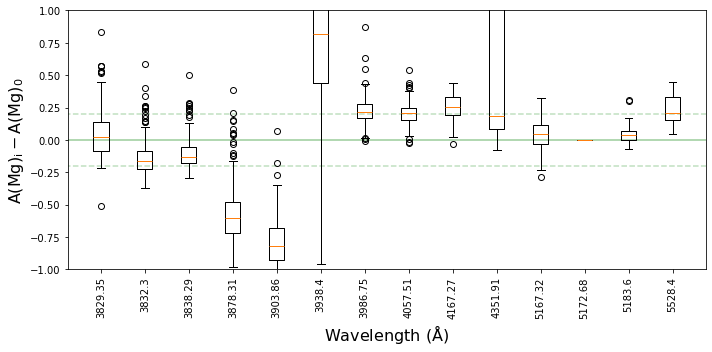

In [55]:
plt.figure(figsize=(10,5))

for n_line, wl_line in enumerate(mg_unique_lines):
    abunds = mg.query('wl_line == %4.2f' %mg_unique_lines[n_line])
    abunds.reset_index(inplace=True)
    # eabunds = mg.query('wl_line == %4.2f' %mg_unique_lines[n_line]).emg_sme.values
    # wl = mg.query('wl_line == %4.2f' %mg_unique_lines[n_line]).wl_line.values
    
    plt.boxplot(np.vstack((abunds.mg.values-mg_ref[abunds.index.values])), positions = [n_line], sym='o', widths=0.35, whis=(5, 95), showmeans=False)

# plt.gca().yaxis.grid('True', alpha=0.25, color='grey')
plt.xticks(np.arange(0, mg_unique_lines.size), mg_unique_lines, rotation=90)
plt.ylabel(r'${\rm A(Mg)_i - A(Mg)_0}$', size=16)
plt.xlabel(r'${\rm Wavelength\ (\AA)}$', size=16)
plt.ylim(-3, 3)
plt.ylim(-1, 1)
plt.xlim(-0.75, 13.75)
plt.hlines([-0.20, 0.20], -1, 14, zorder=0, color='g', alpha=0.25, ls='--', lw=1.5)
plt.hlines(0.0, -1, 14, zorder=-1, color='g', alpha=0.4, ls='-', lw=1.5)

plt.tight_layout()
plt.show()

In [21]:
#Ca

In [30]:
ca_ref = ca.query('wl_line == %4.2f' %ca_unique_lines[-4]).ca.values

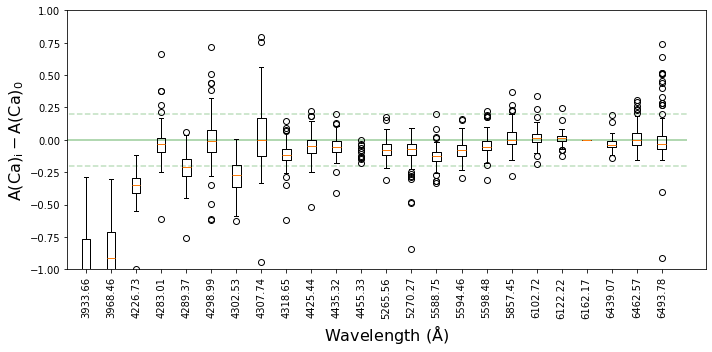

In [34]:
plt.figure(figsize=(10,5))

for n_line, wl_line in enumerate(ca_unique_lines):
    abunds = ca.query('wl_line == %4.2f' %ca_unique_lines[n_line])
    abunds.reset_index(inplace=True)
    # eabunds = mg.query('wl_line == %4.2f' %mg_unique_lines[n_line]).emg_sme.values
    # wl = mg.query('wl_line == %4.2f' %mg_unique_lines[n_line]).wl_line.values
    
    plt.boxplot(np.vstack((abunds.ca.values-ca_ref[abunds.index.values])), positions = [n_line], sym='o', widths=0.35, whis=1.5, showmeans=False)

# plt.gca().yaxis.grid('True', alpha=0.25, color='grey')
plt.xticks(np.arange(0, ca_unique_lines.size), ca_unique_lines, rotation=90)
plt.ylabel(r'${\rm A(Ca)_i - A(Ca)_0}$', size=16)
plt.xlabel(r'${\rm Wavelength\ (\AA)}$', size=16)
plt.ylim(-3, 3)
plt.ylim(-1, 1)
plt.xlim(-0.75, 24.75)
plt.hlines([-0.20, 0.20], -1, 24, zorder=0, color='g', alpha=0.25, ls='--', lw=1.5)
plt.hlines(0.0, -1, 24, zorder=-1, color='g', alpha=0.4, ls='-', lw=1.5)

plt.tight_layout()
plt.show()

In [ ]:
#Ti

In [30]:
ti_ref = ti.query('wl_line == %4.2f' %ti_unique_lines[-1]).ti.values

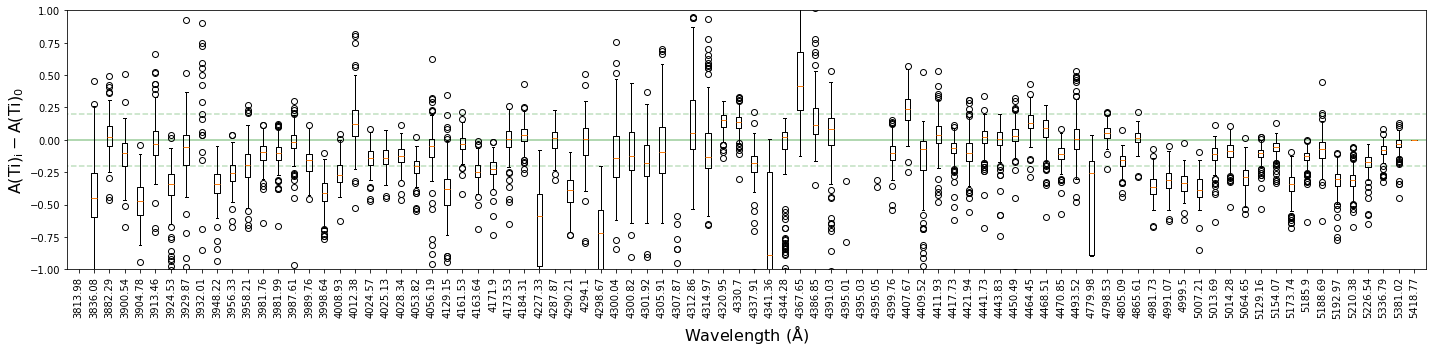

In [200]:
plt.figure(figsize=(20,5))

for n_line, wl_line in enumerate(ti_unique_lines):
    abunds = ti.query('wl_line == %4.2f' %ti_unique_lines[n_line])
    abunds.reset_index(inplace=True)
    # eabunds = ti.query('wl_line == %4.2f' %ti_unique_lines[n_line]).eti_sme.values
    # wl = ti.query('wl_line == %4.2f' %ti_unique_lines[n_line]).wl_line.values
    
    plt.boxplot(abunds.ti.values-ti_ref[abunds.index.values], positions = [n_line], sym='o', widths=0.35, whis=1.5, showmeans=False)

plt.xticks(np.arange(0, ti_unique_lines.size), ti_unique_lines, rotation=90)
plt.ylabel(r'${\rm A(Ti)_i - A(Ti)_0}$', size=16)
plt.xlabel(r'${\rm Wavelength\ (\AA)}$', size=16)
# plt.ylim(-3, 3)
plt.ylim(-1, 1)
plt.xlim(-0.75, 87.75)
# plt.grid(True)
plt.hlines([-0.20, 0.20], -1, 89, zorder=0, color='g', alpha=0.25, ls='--', lw=1.5)
plt.hlines(0.0, -1, 89, zorder=-1, color='g', alpha=0.4, ls='-', lw=1.5)

plt.tight_layout()
plt.show()

In [177]:
ni_ref = ni.query('wl_line == %4.2f' %ni_unique_lines[5]).ni.values

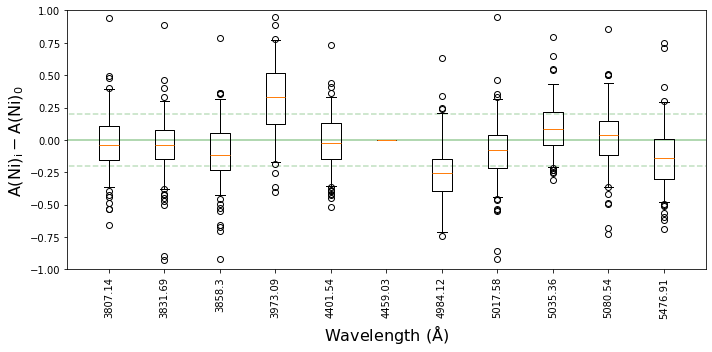

In [208]:
plt.figure(figsize=(10,5))

for n_line, wl_line in enumerate(ni_unique_lines):
    abunds = ni.query('wl_line == %4.2f' %ni_unique_lines[n_line]).ni.values
    eabunds = ni.query('wl_line == %4.2f' %ni_unique_lines[n_line]).eni_sme.values
    wl = ni.query('wl_line == %4.2f' %ni_unique_lines[n_line]).wl_line.values
    
    plt.boxplot(np.vstack((abunds-ni_ref)), positions = [n_line], sym='o', widths=0.35, whis=(5, 95), showmeans=False)

# plt.gca().yaxis.grid('True', alpha=0.25, color='grey')
plt.xticks(np.arange(0, ni_unique_lines.size), ni_unique_lines, rotation=90)
plt.ylabel(r'${\rm A(Ni)_i - A(Ni)_0}$', size=16)
plt.xlabel(r'${\rm Wavelength\ (\AA)}$', size=16)
# plt.ylim(-3, 3)
plt.ylim(-1, 1)
plt.xlim(-0.75, 10.75)
plt.hlines([-0.20, 0.20], -1, 11, zorder=0, color='g', alpha=0.25, ls='--', lw=1.5)
plt.hlines(0.0, -1, 11, zorder=-1, color='g', alpha=0.4, ls='-', lw=1.5)

plt.tight_layout()
plt.show()

In [20]:
ni = pd.read_csv('tmp_elems/uves_elem_lines_eu_4450279330676186368_3576301_057.csv')

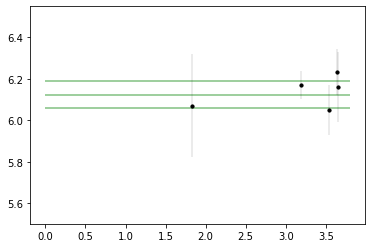

In [129]:
f_ep = ni.eeu_sme.values < 0.25
plt.scatter(ni.excit.values[f_ep], ni.ni.values[f_ep], s=10, color='k')
plt.errorbar(ni.excit.values[f_ep], ni.ni.values[f_ep], fmt='k.', yerr=ni.eni_sme.values[f_ep], alpha=0.1)
avg = np.average(ni.ni.values[f_ep], weights=ni.eni_sme.values[f_ep])
plt.hlines(avg, 0.0, 3.8, color='g', zorder=0, alpha=0.5)
plt.hlines(avg + np.average((ni.ni.values[f_ep] - avg)**2., weights=ni.eni_sme.values[f_ep])**0.5, 0.0, 3.8, color='g', zorder=0, alpha=0.5)
plt.hlines(avg - np.average((ni.ni.values[f_ep] - avg)**2., weights=ni.eni_sme.values[f_ep])**0.5, 0.0, 3.8, color='g', zorder=0, alpha=0.5)
plt.ylim(5.5, 6.55)
plt.show()

In [18]:
#Plots for checking fits

In [38]:
sme_ba_1 = SME_Structure.load('sme_save/uves_elem_sr_lines_6833339632756724992_3573697_118_4215.52.sme')
sme_ba_2 = SME_Structure.load('sme_save/uves_elem_sr_lines_4433115644928113792_3573715_090_4215.52.sme')

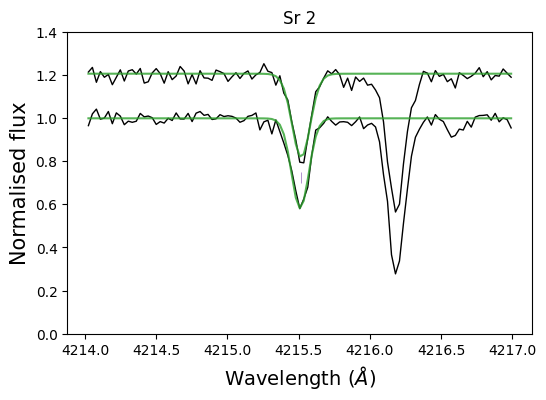

In [40]:
plt.figure(figsize=(6,4), dpi=100)

plt.plot(sme_ba_1.wave.data, sme_ba_1.spec.data, color='k', lw=1)
plt.plot(sme_ba_2.wave.data, sme_ba_2.spec.data+0.2, color='k', lw=1)
# plt.errorbar(sme.wave.data, sme.spec.data, fmt='k', yerr=sme.uncs.data, lw=1, ms=1)
plt.plot(sme_ba_1.wave.data, sme_ba_1.synth.data, color='C2', lw=1.5, alpha=0.8)
plt.plot(sme_ba_2.wave.data, sme_ba_2.synth.data+0.2, color='C2', lw=1.5, alpha=0.8)

# plt.scatter(sme.wave.data, sme.mask.data, s=10, color='grey', alpha=0.2)

elems_to_include = ['Sr 2']
for wline, species in pd.DataFrame(sme_ba_1.linelist)[['wlcent', 'species']].values:
    if 'H 1' in species:
        continue
    if (species == 'Fe 1') | (species == 'Fe 2'):
        plt.vlines(wline, 0.1, 0.15, color='r')
    if species not in elems_to_include:
        plt.vlines(wline, 0.1, 0.15, color='g', alpha=0.2)
        # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)
        continue
    
    plt.vlines(wline, 0.20+0.5, 0.25+0.5, color='C4', lw=0.5)
    # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)
plt.title('%s' %elems_to_include[0])
# plt.xlim(4000, 4020)
# plt.xlim(4128, 4131.5) #Eu
# plt.xlim(4129.5, 4130) #Eu
# plt.xlim(4203, 4207) #Eu
# plt.xlim(3815, 3825)

# plt.xlim(4125, 4135) #Ba
# plt.xlim(4164, 4168) #Ba
# plt.xlim(4285, 4290) #Ba
# plt.xlim(4552, 4556) #Ba
# plt.xlim(4932, 4936) #Ba

# plt.xlim(4213, 4219) #Sr
# plt.xlim(4075, 4080) #Sr
plt.ylim(0.0, 1.4)

plt.xlabel(r'Wavelength ($\AA$)', size=14)
plt.ylabel('Normalised flux', size=15)
plt.show()

In [29]:
sme.fitresults.uncertainties, sme.vrad, sme.fitresults.values, sme.fitresults.uncertainties, sme.fitresults.fit_uncertainties

(array([0.505402]),
 array([-10.]),
 array([0.40501173]),
 array([0.505402]),
 [0.12312492870768511])

In [18]:
#Plots for Kim

In [20]:
cayrel = pd.read_csv('tmp_merged/cayrel_atm_fe_cn_corr.csv')
cayrel['feh'] = cayrel.fe.values + cayrel.monh.values - solar.abund.get_element('Fe')
cayrel.drop_duplicates(subset='spec_id', keep='first', inplace=True)
uves = pd.read_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_uncs_fe_c_corr_n.csv')
uves['feh'] = uves.fe.values + uves.monh.values - solar.abund.get_element('Fe')

In [21]:
mn_merged = pd.read_csv('abunds_merged/uves_lines_mn1_merged.csv')
mn_nlte_merged = pd.read_csv('abunds_merged/uves_lines_mn1_nlte_merged.csv')

cayrel_mn_merged = pd.read_csv('abunds_merged/cayrel_lines_mn1_merged.csv')
cayrel_mn_nlte_merged = pd.read_csv('abunds_merged/cayrel_lines_mn1_nlte_merged.csv')

In [22]:
cayrel = cayrel.merge(right=cayrel_mn_merged, on='spec_id').merge(right=cayrel_mn_nlte_merged, on='spec_id')
uves = uves.merge(right=mn_merged, on='spec_id').merge(right=mn_nlte_merged, on='spec_id')

In [ ]:
 # T = 4700 logg=1.7 [Fe/H]=3.5

In [27]:
cayrel.query('4500 < teff < 4900 and 1.5 < logg < 1.9 and -3.7 < feh < -3.3')

,spec_id,teff,eteff_sme,eteff_fit,logg,elogg_sme,elogg_fit,monh,emonh_sme,emonh_fit,...,mn1,emn1_rms,emn1_sme,n_lines_mn1,min_iters_mn1,mn1_nlte,emn1_nlte_rms,emn1_nlte_sme,n_lines_mn1_nlte,min_iters_mn1_nlte
23,24_CS22952_15,4660.101261,217.665796,13.819773,1.77424,0.067447,0.067447,-3.466339,0.215841,0.013846,...,5.048913,0.292231,0.274,17,9,5.222787,0.276334,0.211,18,10


In [28]:
uves.query('4500 < teff < 4900 and 1.5 < logg < 1.9 and -3.7 < feh < -3.3')

,source_id,ebv,g0,eg,bp0,ebp,rp0,erp,cahk0,ecahk,...,mn1,emn1_rms,emn1_sme,n_lines_mn1,min_iters_mn1,mn1_nlte,emn1_nlte_rms,emn1_nlte_sme,n_lines_mn1_nlte,min_iters_mn1_nlte
62,4854289415101796608,0.025977,11.732175,0.002766,12.225541,0.002870,11.067253,0.003805,13.315854,0.007568,...,5.196288,0.131349,0.327,15,8,5.325269,0.161521,0.242,15,7
70,5735381717990313216,0.069542,11.434156,0.002769,11.871455,0.002853,10.815127,0.003794,12.824030,0.006521,...,4.873458,0.192321,0.526,15,7,5.132651,0.180521,0.545,15,9
103,6488378098744387968,0.013604,12.511802,0.002769,13.016432,0.002892,11.838454,0.003800,14.186291,0.009785,...,4.590002,0.358693,0.810,15,7,4.804664,0.284560,0.867,15,1
139,6776164134760319488,0.072589,12.495339,0.002763,12.973717,0.002853,11.842886,0.003804,14.022838,0.008617,...,5.435044,0.131549,0.395,14,8,5.594616,0.145661,0.381,14,7


In [89]:
#Save files for Kim

In [90]:
def pix_to_wl(pix, wl0, dwl):
    return wl0 + pix * dwl

In [91]:
star = sorted(glob.glob('/store/teams/cosmos/hill/hill_extern7bis/LP/LPgiants/*/'))[:-1][23]

header_spb = pd.read_csv('%s/spb' %star, nrows=1, skiprows=1, names=['npix', 'dpix', 'wl0', 'dwl', 'rv'], delim_whitespace=True)    
data_spb = pd.read_csv('%s/spb' %star, nrows=header_spb.npix.values[0], skiprows=3, names=['pix', 'flux'], delim_whitespace=True, comment='-')
data_spb.dropna(axis=0, inplace=True)

wave_spb = pix_to_wl(data_spb.pix.values, header_spb.wl0.values[0], header_spb.dwl.values[0]) * np.sqrt((1.-(header_spb.rv[0]*1000.)/c.value)/(1.+(header_spb.rv[0]*1000.)/c.value))
spec_spb = data_spb.flux.values/10000.
uncs_spb = 0.001*np.ones_like(data_spb.flux.values)

header_spvl = pd.read_csv('%s/spvl' %star, nrows=1, skiprows=1, names=['npix', 'dpix', 'wl0', 'dwl', 'rv'], delim_whitespace=True)    
data_spvl = pd.read_csv('%s/spvl' %star, nrows=header_spb.npix.values[0], skiprows=3, names=['pix', 'flux'], delim_whitespace=True, comment='-')
data_spvl.dropna(axis=0, inplace=True)

wave_spvl = pix_to_wl(data_spvl.pix.values, header_spvl.wl0.values[0], header_spvl.dwl.values[0]) * np.sqrt((1.-(header_spvl.rv[0]*1000.)/c.value)/(1.+(header_spvl.rv[0]*1000.)/c.value))
spec_spvl = data_spvl.flux.values/10000.
uncs_spvl = 0.001*np.ones_like(data_spvl.flux.values)

In [92]:
cayrel_24 = pd.DataFrame(data = np.vstack((np.hstack((wave_spb, wave_spvl)).T, np.hstack((spec_spb, spec_spvl)).T, np.hstack((uncs_spb, uncs_spvl)).T)).T, columns=['wl', 'flux', 'eflux'])
cayrel_24.to_csv('/home/fgran/Cayrel_24_CS22952_15_KVenn.csv', header=True, index=False)

In [93]:
cayrel_24_mn_sme_lines = glob.glob('sme_save/cayrel_elem_mn_lines_24_CS22952_15_*')
cayrel_24_sme = pd.DataFrame(columns=['wl', 'flux', 'eflux'])

for cayrel_24_mn_sme_line in cayrel_24_mn_sme_lines:
    sme = SME_Structure.load(cayrel_24_mn_sme_line)
    cayrel_24_sme = pd.concat([cayrel_24_sme, pd.DataFrame(data = np.vstack((sme.wave.data, sme.synth.data, np.zeros_like(sme.wave.data))).T, columns=['wl', 'flux', 'eflux'])], ignore_index=True)

cayrel_24_sme.reset_index(inplace=True, drop=True)
cayrel_24_sme.sort_values(by='wl', inplace=True)

In [94]:
cayrel_24.to_csv('/home/fgran/Cayrel_pysme_synth_mn_24_CS22952_15_KVenn.csv', header=True, index=False)

In [99]:
for i, star in uves.query('4500 < teff < 4900 and 1.5 < logg < 1.9 and -3.7 < feh < -3.3').iterrows():
    blue_spec = ispec.read_spectrum('norm_RV_corr/%s/blue_%s' %(star.run, star.blue_file))
    blue_spec.waveobs = blue_spec.waveobs * 10.
    blue_spec.err[blue_spec.err == 0.0] = 1.0
    red1_spec = ispec.read_spectrum('norm_RV_corr/%s/red1_%s' %(star.run, star.red_file))
    red1_spec.waveobs = red1_spec.waveobs * 10.
    red1_spec.err[red1_spec.err == 0.0] = 1.0

    uves_mn = pd.DataFrame(data = np.vstack((np.hstack((blue_spec.waveobs, red1_spec.waveobs)).T, np.hstack((blue_spec.flux, red1_spec.flux)).T, np.hstack((blue_spec.err, red1_spec.err)).T)).T, 
                           columns=['wl', 'flux', 'eflux'])
    uves_mn.to_csv('/home/fgran/UVES_%s_KVenn.csv' %star.spec_id, header=True, index=False)

In [100]:
for i, star in uves.query('4500 < teff < 4900 and 1.5 < logg < 1.9 and -3.7 < feh < -3.3').iterrows():

    uves_mn_sme_lines = glob.glob('sme_save/uves_elem_mn_lines_%s_*' %star.spec_id)
    uves_sme = pd.DataFrame(columns=['wl', 'flux', 'eflux'])
    
    for uves_mn_sme_line in uves_mn_sme_lines:
        sme = SME_Structure.load(uves_mn_sme_line)
        uves_sme = pd.concat([uves_sme, pd.DataFrame(data = np.vstack((sme.wave.data, sme.synth.data, np.zeros_like(sme.wave.data))).T, columns=['wl', 'flux', 'eflux'])], ignore_index=True)
    
    uves_sme.reset_index(inplace=True, drop=True)
    uves_sme.sort_values(by='wl', inplace=True)

    uves_sme.to_csv('/home/fgran/UVES_pysme_synth_mn_%s_KVenn.csv' %star.spec_id, header=True, index=False)

In [123]:
# Save table

In [126]:
cayrel = pd.read_csv('tmp_merged/cayrel_atm_fe_cn_corr.csv')
cayrel['feh'] = cayrel.fe.values + cayrel.monh.values - solar.abund.get_element('Fe')
cayrel.drop_duplicates(subset='spec_id', keep='first', inplace=True)
uves = pd.read_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_uncs_fe_c_corr_n.csv')
uves['feh'] = uves.fe.values + uves.monh.values - solar.abund.get_element('Fe')

cayrel = cayrel.merge(right=cayrel_mn_merged, on='spec_id').merge(right=cayrel_mn_nlte_merged, on='spec_id')
cayrel['mnfe'] = cayrel.mn1.values - solar.abund.get_element('Mn')
cayrel['mnfe_nlte'] = cayrel.mn1_nlte.values - solar.abund.get_element('Mn')
cayrel_24_mn_table = cayrel.query('4500 < teff < 4900 and 1.5 < logg < 1.9 and -3.7 < feh < -3.3')[['spec_id', 'teff', 'logg', 'feh', 'mnfe', 'mnfe_nlte']]

In [128]:
uves = uves.merge(right=mn_merged, on='spec_id').merge(right=mn_nlte_merged, on='spec_id')
uves['mnfe'] = uves.mn1.values - solar.abund.get_element('Mn')
uves['mnfe_nlte'] = uves.mn1_nlte.values - solar.abund.get_element('Mn')
uves_mn_table = uves.query('4500 < teff < 4900 and 1.5 < logg < 1.9 and -3.7 < feh < -3.3')[['spec_id', 'teff', 'logg', 'feh', 'mnfe', 'mnfe_nlte']]

In [130]:
mn_table = pd.concat([cayrel_24_mn_table, uves_mn_table], ignore_index=True)

In [132]:
mn_table.to_csv('/home/fgran/UVES_Cayrel_Mn_table.csv', index=False, header=True)

In [133]:
mn_table

,spec_id,teff,logg,feh,mnfe,mnfe_nlte
0,24_CS22952_15,4660.101261,1.774240,-3.421317,-0.381087,-0.207213
1,4854289415101796608_3708430_135,4508.978338,1.545356,-3.449522,-0.233712,-0.104731
2,5735381717990313216_3572855_004,4804.281488,1.745076,-3.325713,-0.556542,-0.297349
3,6488378098744387968_3576337_082,4656.622167,1.614050,-3.532186,-0.839998,-0.625336
4,6776164134760319488_3576358_062,4621.659873,1.618898,-3.344374,0.005044,0.164616


In [23]:
sme_mn1 = SME_Structure.load('sme_save/uves_elem_mn_lines_6488378098744387968_3576337_082_4030.76.sme')
sme_mn2 = SME_Structure.load('sme_save/uves_elem_mn_lines_6488378098744387968_3576337_082_4033.70.sme')

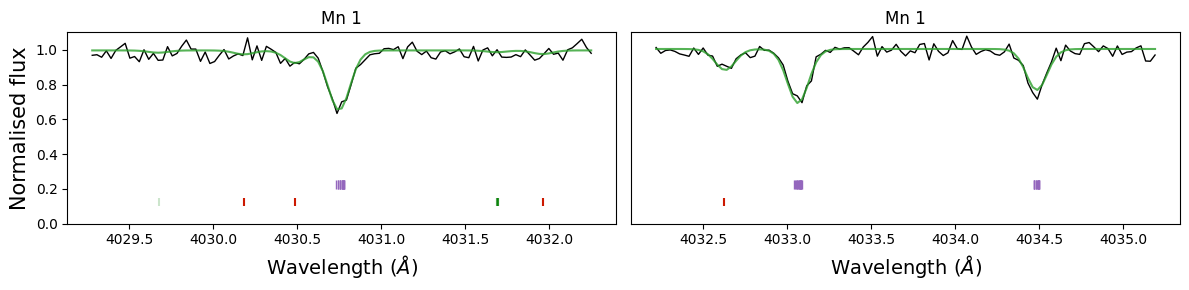

In [24]:
plt.figure(figsize=(12,3), dpi=100)
plt.subplots_adjust(wspace=0.01)

plt.subplot(1,2,1)

plt.plot(sme_mn1.wave.data, sme_mn1.spec.data, color='k', lw=1)
plt.plot(sme_mn1.wave.data, sme_mn1.synth.data, color='C2', lw=1.5, alpha=0.8)

elems_to_include = ['Mn 1']
for wline, species in pd.DataFrame(sme_mn1.linelist)[['wlcent', 'species']].values:
    if 'H 1' in species:
        continue
    if (species == 'Fe 1') | (species == 'Fe 2'):
        plt.vlines(wline, 0.1, 0.15, color='r')
        # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)
    if species not in elems_to_include:
        plt.vlines(wline, 0.1, 0.15, color='g', alpha=0.2)
        # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)
        continue
    
    plt.vlines(wline, 0.20, 0.25, color='C4', lw=1)
    # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)

plt.title('%s' %elems_to_include[0])
plt.ylim(0.0, 1.1)
plt.xlabel(r'Wavelength ($\AA$)', size=14)
plt.ylabel('Normalised flux', size=15)


plt.subplot(1,2,2)

plt.plot(sme_mn2.wave.data, sme_mn2.spec.data, color='k', lw=1)
plt.plot(sme_mn2.wave.data, sme_mn2.synth.data, color='C2', lw=1.5, alpha=0.8)

elems_to_include = ['Mn 1']
for wline, species in pd.DataFrame(sme_mn2.linelist)[['wlcent', 'species']].values:
    if 'H 1' in species:
        continue
    if (species == 'Fe 1') | (species == 'Fe 2'):
        plt.vlines(wline, 0.1, 0.15, color='r')
        # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)
    if species not in elems_to_include:
        plt.vlines(wline, 0.1, 0.15, color='g', alpha=0.2)
        # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)
        continue
    
    plt.vlines(wline, 0.20, 0.25, color='C4', lw=1)
    # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)

plt.title('%s' %elems_to_include[0])
plt.yticks([])
plt.ylim(0.0, 1.1)
plt.xlabel(r'Wavelength ($\AA$)', size=14)

plt.tight_layout()
plt.savefig('plots/uves_mn_kvenn_issi.pdf', dpi=100)
plt.show()

In [25]:
sme_mn1.fitresults.values, sme_mn2.fitresults.values

(array([4.2290206]), array([4.3028507]))

In [387]:
#Merging individual abundance files

In [389]:
lines = pd.read_csv('tmp_elems/uves_elem_lines_ti_3608416056475856512_3708499_157.csv')
lines.head()

,spec_id,species,wl_line,excit,gflog,ti,eti_sme,eti_fit,n_iter_ti
0,3608416056475856512_3708499_157,Ti 1,3904.78,0.8995,0.150,4.828,0.341,0.242,18
1,3608416056475856512_3708499_157,Ti 1,3924.53,0.0211,-0.870,4.897,0.200,0.049,13
2,3608416056475856512_3708499_157,Ti 1,3929.87,0.0000,-0.990,6.500,1.633,0.360,14
3,3608416056475856512_3708499_157,Ti 1,3948.22,0.0211,-0.890,3.161,0.000,0.000,16
4,3608416056475856512_3708499_157,Ti 1,3956.33,0.0211,-0.512,4.945,0.348,0.100,16


In [386]:
# f_lines = (lines.eni_sme.values != 0.0) & (lines.eni_sme.values < 10)
# average = np.average(a = lines.ni.values[f_lines], weights=1./lines.eni_sme.values[f_lines]**2.)

# variance = np.average((average - lines.ni.values[f_lines])**2., weights=1./lines.eni_sme.values[f_lines]**2.)

# np.sqrt(variance), np.std(lines.ni.values[f_lines])

# lines.query('gflog < -2')

In [512]:
def merge_abund_files(elem_to_merge, spec_ids, monhs, ion_to_merge = None, wls_to_filter = None, wls_to_correct = None, gflogs_shift = None):

    for spec_id, monh in zip(spec_ids, monhs):
        df = pd.read_csv('tmp_elems/uves_elem_lines_%s_%s.csv' %(elem_to_merge, spec_id))
        # print(df)
        if ion_to_merge != None: df = df.query('species == "%s"' %ion_to_merge)

        if wls_to_filter is not None:
            for wl_to_filter in wls_to_filter:
                if wl_to_filter in np.unique(df.wl_line.values):
                    df = df.query('wl_line != %4.2f' %wl_to_filter)
                    df.reset_index(inplace=True)

        if (wls_to_correct is not None) and (gflogs_shift is not None):
            for wl_to_correct, gflog_shift in zip(wls_to_correct, gflogs_shift):
                if wl_to_correct in np.unique(df.wl_line.values):
                    df.loc[df.query('wl_line == %4.2f' %wl_to_correct).index.values, '%s' %elem_to_merge] = df.query('wl_line == %4.2f' %wl_to_correct)['%s' %elem_to_merge].values + gflog_shift
                    
        df['loge%s' %elem_to_merge.capitalize()] = df['%s' %elem_to_merge].values + monh
    
        condition = '%s < 10 and e%s_sme < 0.5 and e%s_sme != 0.0 and n_iter_%s > 1' %(elem_to_merge, elem_to_merge, elem_to_merge, elem_to_merge)
        df = df.query(condition)
        print(df)

        if df.spec_id.size > 1:
            average = np.average(a = df['%s' %elem_to_merge].values, weights=1./df['e%s_sme' %elem_to_merge].values**2.)
            rms = np.average((average - df['%s' %elem_to_merge].values)**2., weights=1./df['e%s_sme' %elem_to_merge].values**2.)**0.5
            e_sme_mean = np.mean(df['e%s_sme' %elem_to_merge].values)
            n_lines = df['e%s_sme' %elem_to_merge].size
            min_n_iters, max_n_iters = np.min(df['n_iter_%s' %elem_to_merge].values), np.max(df['n_iter_%s' %elem_to_merge].values)
        else:
            average = df['%s' %elem_to_merge].values
            rms = df['e%s_sme' %elem_to_merge].values
            e_sme_mean = df['%s' %elem_to_merge].values
            n_lines = 1
            min_n_iters, max_n_iters = np.min(df['n_iter_%s' %elem_to_merge].values), np.max(df['n_iter_%s' %elem_to_merge].values)

        print(average, rms, e_sme_mean, n_lines, min_n_iters, max_n_iters)
        
        return
    
    return

In [513]:
merge_abund_files('mg', uves.spec_id.values, uves.monh.values, ion_to_merge='Mg 1', wls_to_correct = [3986.75, 4057.51], gflogs_shift = [-0.1, -0.2])

                            spec_id species  wl_line   excit  gflog     mg  \
2   1166634514845213568_3572891_000    Mg 1  3838.29  2.7166 -1.527  7.758   
3   1166634514845213568_3572891_000    Mg 1  3878.31  4.3458 -0.457  7.137   
6   1166634514845213568_3572891_000    Mg 1  3986.75  4.3458 -1.060  7.954   
7   1166634514845213568_3572891_000    Mg 1  4057.51  4.3458 -0.900  7.938   
10  1166634514845213568_3572891_000    Mg 1  5167.32  2.7091 -0.931  7.947   
11  1166634514845213568_3572891_000    Mg 1  5172.68  2.7116 -0.450  7.888   
12  1166634514845213568_3572891_000    Mg 1  5183.60  2.7166 -0.239  7.964   

    emg_sme  emg_fit  n_iter_mg    logeMg  
2     0.393    0.056         13  4.980851  
3     0.415    0.154         14  4.359851  
6     0.456    0.096         18  5.176851  
7     0.222    0.060         12  5.160851  
10    0.415    0.051         13  5.169851  
11    0.351    0.042         15  5.110851  
12    0.218    0.031         12  5.186851  
7.861342286857882 0.221

In [7]:
uves = pd.read_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_uncs_fe_c_corr_n.csv')

In [8]:
%%time

elem_to_merge = ['mg']
uves_line_by_line = pd.DataFrame()
merged_spec_id = np.empty_like(uves.teff.values, dtype=object)
merged_elem, merged_logeelem, merged_eelem_rms = np.empty_like(uves.teff.values), np.empty_like(uves.teff.values), np.empty_like(uves.teff.values)
merged_eelem_sme, merged_lines = np.empty_like(uves.teff.values), np.empty_like(uves.teff.values)
is_limit_elem = np.empty_like(uves.teff.values, dtype=bool)

for j, elem in enumerate(elem_to_merge):

    elem_lines_files = sorted(glob.glob('tmp_elems/uves_elem_lines_%s_*' %elem))

    for i, elem_lines_file in enumerate(elem_lines_files):

        df = pd.read_csv(elem_lines_file)
        df['loge%s' %elem.capitalize()] = df['%s' %elem].values + uves.monh.values[i]
        condition = 'e%s_sme < 10' %(elem)

        if df.query(condition).spec_id.size == 0:
            df = df.sort_values(by='e%s_sme' %elem, ascending=True)
            
            merged_spec_id[i] = df.spec_id.values[0]
            merged_elem[i] = df['%s' %elem].values[0]
            merged_logeelem[i] = df['loge%s' %elem.capitalize()].values[0]
            merged_eelem_rms[i] = df['e%s_sme' %elem].values[0]
            merged_eelem_sme[i] = df['e%s_sme' %elem].values[0]
            merged_lines = df['n_iter_%s' %elem].size
            is_limit_elem[i] = True
        else:
            df = df.query(condition)
            merged_spec_id[i] = df.spec_id.values[0]
            merged_elem[i] = np.average(a = df['%s' %elem].values, weights=1./df['e%s_sme' %elem].values**2.)
            merged_logeelem[i] = np.average(a = df['loge%s' %elem.capitalize()].values, weights=1./df['e%s_sme' %elem].values**2.)
            merged_eelem_rms[i] = np.std(df['loge%s' %elem.capitalize()].values)
            merged_eelem_sme[i] = np.sqrt(np.sum(df['e%s_sme' %elem].values**2.))
            merged_lines = df['n_iter_%s' %elem].size
            is_limit_elem[i] = False

    if j == 0:
        uves_line_by_line['spec_id'] = merged_spec_id
    uves_line_by_line['loge%s' %elem.capitalize()] = merged_logeelem
    uves_line_by_line['%s' %elem] = merged_elem
    uves_line_by_line['e%s_rms' %elem] = merged_eelem_rms
    uves_line_by_line['e%s_sme' %elem] = merged_eelem_sme
    uves_line_by_line['%s_nlines' %elem] = merged_lines
    uves_line_by_line['is_limit_%s' %elem] = is_limit_elem

CPU times: user 594 ms, sys: 11.2 ms, total: 605 ms
Wall time: 23.2 s


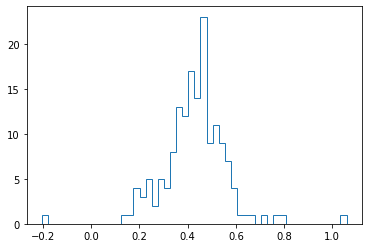

In [10]:
plt.hist(uves_line_by_line.mg.values-7.60, bins=50, histtype='step')
plt.show()

In [21]:
# OLD MATERIAL. UP HERE: Cayrel TESTED CODE

In [137]:
def sme_init(wave, spec, uncs, teff, logg, monh, vmic, vmac, vrad, abund, vrad_flag, linelist, ipress, vrad_bounds, elems_to_include):

    #SME definitions
    sme = SME_Structure()

    sme.ipres, sme.iptype, sme.gam6, sme.h2broad = ipress, 'gauss', True, True
    sme.atmo.source, sme.atmo.method, sme.atmo.geom = 'marcs2012s_t2.0.sav', 'grid', 'SPH'

    sme.accxt, sme.accgt, sme.accft = tol, tol, tol
    sme.leastsquare3_ftol, sme.leastsquares_gtol, sme.leastsquares_xtol = tol, tol, tol
    sme.accwi, sme.accrt, sme.clim, sme.chirat = tol, tol, tol, tol
    sme.vrad_bounds = vrad_bounds

    # Redirect output to logs/RUN*/*.txt
    util.start_logging(log_file='logs/UVES_atm.txt', level='ERROR')

    sme.cscale_flag = 'constant'
    # sme.cscale = 1.0
    sme.cscale_type = 'mask'
    sme.fitresults.maxiter = 25

    sme.wave = wave
    sme.spec = spec
    sme.uncs = uncs

    # The mask values are: 0: bad pixel, 1: line pixel, 2: continuum pixel
    line_regions = cont_mask.mask_values.values
    ll_mask = np.zeros(linelist.species.size).astype(bool)
    
    for wline, mask_species in linelist[['wlcent', 'species']]:
        if mask_species in elems_to_include:
            idx_ = (sme.wave.data > wline-delta_line) & (sme.wave.data < wline+delta_line)
            line_regions[idx_] = 1
            
            ll_mask[(linelist.wlcent > wline-delta_line) & (linelist.wlcent < wline+delta_line)] = True
            continue
        
    for wline, mask_species in linelist[['wlcent', 'species']]:
        #Hydrogen lines
        if 'H 1' == mask_species:
            idx_ = (sme.wave.data > wline-delta_Halpha) & (sme.wave.data < wline+delta_Halpha)
            line_regions[idx_] = 0
    del idx_
    
    #G-band and CaHK regions
    # line_regions[(sme.wave.data > wl_G_band-delta_G_band) & (sme.wave.data < wl_G_band+delta_G_band)] = 0
    # line_regions[(sme.wave.data > wl_CaHK_band-delta_CaHK_band) & (sme.wave.data < wl_CaHK_band+delta_CaHK_band)] = 0
    # line_regions[sme.wave.data < 4000] = 0
    #Merge all the line_regions as int
    line_regions = line_regions.astype(int)
    line_regions[sme.spec.data == 0.0] = 0
    sme.mask = line_regions
    del line_regions

    sme.linelist = linelist[ll_mask]
    del ll_mask

    #Abundance scaling to create realistic synthetics
    sme.abund = abund
    #RV determination for each chip
    sme.vrad_flag = vrad_flag

    #input guesses from xgboost
    sme.teff = teff
    sme.logg = logg
    sme.monh = monh
    sme.vmic = vmic
    sme.vmac = vmac
    sme.vrad = vrad
    
    return sme

In [146]:
def sme_parallel(i, input_row, elems_to_include, elem_string, vrad_flag, ipress, tol=1e-2):

    #Load data to create SME structures
    blue_spec = ispec.read_spectrum('norm_RV_corr/%s/blue_%s' %(input_row.run, input_row.blue_file))
    blue_spec.waveobs = blue_spec.waveobs * 10.
    blue_spec.err[blue_spec.err == 0.0] = 1.0
    red1_spec = ispec.read_spectrum('norm_RV_corr/%s/red1_%s' %(input_row.run, input_row.red_file))
    red1_spec.waveobs = red1_spec.waveobs * 10.
    red1_spec.err[red1_spec.err == 0.0] = 1.0
    red2_spec = ispec.read_spectrum('norm_RV_corr/%s/red2_%s' %(input_row.run, input_row.red_file))
    red2_spec.waveobs = red2_spec.waveobs * 10.
    red2_spec.err[red2_spec.err == 0.0] = 1.0

    wave = [blue_spec.waveobs[(blue_spec.waveobs > wmin_blue) & (blue_spec.waveobs < wmax_blue)], 
            red1_spec.waveobs[(red1_spec.waveobs > wmin_red1) & (red1_spec.waveobs < wmax_red1)],
            red2_spec.waveobs[(red2_spec.waveobs > wmin_red2) & (red2_spec.waveobs < wmax_red2)]]
    spec = [blue_spec.flux[(blue_spec.waveobs > wmin_blue) & (blue_spec.waveobs < wmax_blue)],
            red1_spec.flux[(red1_spec.waveobs > wmin_red1) & (red1_spec.waveobs < wmax_red1)],
            red2_spec.flux[(red2_spec.waveobs > wmin_red2) & (red2_spec.waveobs < wmax_red2)]]
    uncs = [1./blue_spec.err[(blue_spec.waveobs > wmin_blue) & (blue_spec.waveobs < wmax_blue)],
            1./red1_spec.err[(red1_spec.waveobs > wmin_red1) & (red1_spec.waveobs < wmax_red1)],
            1./red2_spec.err[(red2_spec.waveobs > wmin_red2) & (red2_spec.waveobs < wmax_red2)]]

    del blue_spec, red1_spec, red2_spec

    #input guesses from xgboost
    teff = input_row.teff
    logg = input_row.logg
    monh = input_row.monh
    vmic = input_row.vmic
    vmac = input_row.vmac
    vrad = [input_row.sme_vrad1, input_row.sme_vrad2, input_row.sme_vrad3]

    sme = sme_init(wave, spec, uncs, teff, logg, monh, vmic, vmac, vrad, abund, vrad_flag, linelist, ipress, vrad_bounds = (-5,5), elems_to_include = elems_to_include)
    del wave, spec, uncs
    
    #NLTE
    sme.nlte.set_nlte('Fe', 'nlte_Fe_ama51_Feb2022_pysme.grd')
    # sme.nlte.set_nlte('H', 'nlte_H_ama51_pysme.grd')
    # sme.nlte.set_nlte('Mg', 'marcs2012_Mg2016.grd')
    # sme.nlte.set_nlte('Ti', 'marcs2012s_t2.0_Ti.grd')
    
    #Do the heavy lifting
    fitparameters = ['abund Fe', 'vmac']
    sme = solve(sme, fitparameters)

    fe, efe_sme, efe_fit = sme.fitresults.values[0], sme.fitresults.uncertainties[0], sme.fitresults.fit_uncertainties[0]
    vmac, evmac_sme, evmac_fit = sme.vmac, sme.fitresults.uncertainties[1], sme.fitresults.fit_uncertainties[1]
    sme_vrad1, sme_vrad2, sme_vrad3 = sme.vrad

    sme.save('sme_save/UVES_%s_nlte_%s' %(elem_string.lower(), input_row.spec_id))
    del sme

    columns_fe = ['spec_id', 'fe', 'efe_sme', 'efe_fit', 'vmac', 'evmac_sme', 'evmac_fit','sme_vrad1', 'sme_vrad2', 'sme_vrad3']
    data_to_write = np.vstack((input_row.spec_id, fe, efe_sme, efe_fit, vmac, evmac_sme, evmac_fit, sme_vrad1, sme_vrad2, sme_vrad3)).T

    del fe, efe_sme, efe_fit, vmac, evmac_sme, evmac_fit, sme_vrad1, sme_vrad2, sme_vrad3

    pd.DataFrame(data=data_to_write, columns=columns_fe).to_csv('tmp_fe/UVES_%s_nlte_%s.csv' %(elem_string.lower(), input_row.spec_id), index=False, header=False)
    del data_to_write

    return

In [147]:
vrad_flag = 'each' # 'each' # 'whole' # 'each'
ipress = 42000

elems_to_include, elem_string, tol = ['Fe 1', 'Fe 2'], 'Fe', 1e-3

In [148]:
uves = pd.read_csv('uves_p111_p112_pristinedr1_xgboost_logg.csv')
uves = uves.merge(pd.read_csv('tmp_merged/UVES_atm.csv'), on='spec_id')
uves.to_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm.csv', header=True, index=False)

In [149]:
%%time
Parallel(n_jobs=-1, verbose=1)(delayed(sme_parallel)(i, input_row, elems_to_include, elem_string, vrad_flag, ipress, tol=tol) for i, input_row in uves.iterrows())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.


CPU times: user 1 s, sys: 1.19 s, total: 2.19 s
Wall time: 15min 32s


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 15.5min finished


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [5]:
#Merge and add header to the files

In [157]:
os.system('cat tmp_fe/UVES_fe1_*.csv > tmp_merged/fe1.csv');
os.system('cat tmp_fe/UVES_fe2_*.csv > tmp_merged/fe2.csv');

os.system('cat tmp_fe/UVES_fe_???????????????????_???????_???.csv > tmp_merged/fe.csv');
os.system('cat tmp_fe/UVES_fe_nlte_*.csv > tmp_merged/fe_nlte.csv');

In [158]:
!sed -i '1i \spec_id,fe1,efe1_sme,efe1_fit,vmac1,evmac1_sme,evmac1_fit,sme1_vrad1,sme1_vrad2,sme1_vrad3' tmp_merged/fe1.csv
!sed -i '1i \spec_id,fe2,efe2_sme,efe2_fit,vmac2,evmac2_sme,evmac2_fit,sme2_vrad1,sme2_vrad2,sme2_vrad3' tmp_merged/fe2.csv

!sed -i '1i \spec_id,fe,efe_sme,efe_fit,vmac,evmac_sme,evmac_fit,sme_vrad1,sme_vrad2,sme_vrad3' tmp_merged/fe.csv
!sed -i '1i \spec_id,fe_nlte,efe_nlte_sme,efe_nlte_fit,vmac_nlte,evmac_nlte_sme,evmac_nlte_fit,sme_nlte_vrad1,sme_nlte_vrad2,sme_nlte_vrad3' tmp_merged/fe_nlte.csv

In [6]:
#Read and merge all files with general uves table 

In [7]:
fe1 = pd.read_csv('tmp_merged/fe1.csv')
fe2 = pd.read_csv('tmp_merged/fe2.csv')

fe = pd.read_csv('tmp_merged/fe.csv')
fe_nlte = pd.read_csv('tmp_merged/fe_nlte.csv')

In [8]:
uves = pd.read_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm.csv')

In [9]:
uves = uves.merge(right=fe1, on='spec_id').merge(right=fe2, on='spec_id').merge(right=fe, on='spec_id').merge(right=fe_nlte, on='spec_id')

In [15]:
uves.to_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_fe.csv', index=False, header=True)

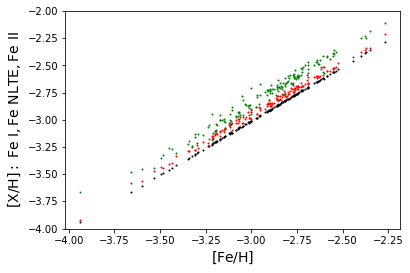

In [14]:
plt.scatter(uves.fe.values + uves.monh.values - 7.50, uves.fe1.values + uves.monh.values - 7.50, s=1, color='k')
plt.scatter(uves.fe.values + uves.monh.values - 7.50, uves.fe_nlte.values + uves.monh.values - 7.50, s=1, color='r')
plt.scatter(uves.fe.values + uves.monh.values - 7.50, uves.fe2.values + uves.monh.values - 7.50, s=1, color='g')
plt.ylim(-4.0, -2.0)

# x = np.linspace(-4, -2)
# plt.plot(x,x,color='C4')


plt.xlabel(r'${\rm [Fe/H]}$', size=14)
plt.ylabel(r'${\rm [X/H]:\ Fe\ I, Fe\ NLTE, Fe\ II}$', size=14)
plt.show()

In [64]:
#Check bad Fe fits

In [65]:
# fe0 = pd.read_csv('tmp_merged/elem_fe_merged.csv')
# uves = pd.read_csv('uves_p111_p112_pristinedr1_xgboost_atm_means_carbon.csv')
# uves.drop(columns=['sme_vrad1', 'sme_vrad2', 'sme_vrad3'], inplace=True)
# uves_fe0 = uves.merge(right=fe0, right_on='spec_id', left_on='spec_id') 

# bad_fe = uves_fe0.query("fe < 7.0")
# bad_fe.ra.size

# %%time

# # Single execution
# elems_to_include, elem_string = ['Fe 1', 'Fe 2'], 'Fe'
# Parallel(n_jobs=-3, verbose=0)(delayed(sme_parallel)(i, input_row, tol=1e-3, elems_to_include=elems_to_include, elem_string=elem_string) for i, input_row in bad_fe.iterrows())

In [26]:
# #For elems different than Fe, sme_vrad must be ingested into the function
# fe0 = pd.read_csv('tmp_merged/elem_fe_merged.csv')
# uves = pd.read_csv('uves_p111_p112_pristinedr1_xgboost_atm_means_carbon.csv')
# uves.drop(columns=['sme_vrad1', 'sme_vrad2', 'sme_vrad3'], inplace=True)
# uves_fe0 = uves.merge(right=fe0, right_on='spec_id', left_on='spec_id')

In [231]:
# # %%time

# # TEST RUN USING ONLY ONE STAR

# vrad_flag = 'fix' # 'fix' # 'whole' # 'each'
# elems_to_include, elem_string, tol = ['O 1'], 'O', 1e-6
# sme = sme_parallel(0, uves.iloc[4], tol=tol, elems_to_include=elems_to_include, elem_string=elem_string, vrad_flag=vrad_flag)

[2024-06-25 22:51:25,969] [WARNING] [sme:_abund:95]: Abundance set using just a pattern, assuming that it has format H=12. If that is incorrect, try changing the format first.
[2024-06-25 22:51:25,971] [INFO] [config:__init__:28]: No cconfiguration file found at /misc/store/home_zztop/fgran/.sme/config.json, using default values instead
[2024-06-25 22:51:25,972] [INFO] [synthesize:__init__:48]: Don't forget to cite your sources. Use sme.citation()
[2024-06-25 22:51:25,974] [INFO] [solve:solve:700]: Fitting Spectrum with Parameters: abund O


WARNING - Abundance set using just a pattern, assuming that it has format H=12. If that is incorrect, try changing the format first.
INFO - No cconfiguration file found at /misc/store/home_zztop/fgran/.sme/config.json, using default values instead
INFO - Don't forget to cite your sources. Use sme.citation()
INFO - Fitting Spectrum with Parameters: abund O


[2024-06-25 22:51:33,120] [INFO] [util:logprint:50]:    Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
[2024-06-25 22:51:33,121] [INFO] [util:logprint:50]:        0              1         6.2880e+02                                    4.64e-04    


INFO -    Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
INFO -        0              1         6.2880e+02                                    4.64e-04    


[2024-06-25 22:51:45,592] [INFO] [util:logprint:50]:        1              3         6.2880e+02      1.01e-03       1.21e+00       6.05e-03    


INFO -        1              3         6.2880e+02      1.01e-03       1.21e+00       6.05e-03    


[2024-06-25 22:51:53,951] [INFO] [util:logprint:50]:        2              4         6.2822e+02      5.83e-01       2.42e+00       1.14e+00    


INFO -        2              4         6.2822e+02      5.83e-01       2.42e+00       1.14e+00    


[2024-06-25 22:52:07,899] [INFO] [util:logprint:50]:        3              6         6.2781e+02      4.09e-01       3.03e-01       1.52e+00    


INFO -        3              6         6.2781e+02      4.09e-01       3.03e-01       1.52e+00    


[2024-06-25 22:52:17,439] [INFO] [util:logprint:50]:        4              7         6.2766e+02      1.47e-01       5.60e-01       3.30e+00    


INFO -        4              7         6.2766e+02      1.47e-01       5.60e-01       3.30e+00    


[2024-06-25 22:52:26,699] [INFO] [util:logprint:50]:        5              8         6.2740e+02      2.62e-01       1.70e-01       2.16e-01    


INFO -        5              8         6.2740e+02      2.62e-01       1.70e-01       2.16e-01    


[2024-06-25 22:52:35,935] [INFO] [util:logprint:50]:        6              9         6.2740e+02      5.22e-03       1.87e-02       9.25e-03    


INFO -        6              9         6.2740e+02      5.22e-03       1.87e-02       9.25e-03    


[2024-06-25 22:52:45,170] [INFO] [util:logprint:50]:        7             10         6.2740e+02      1.90e-05       8.52e-04       2.99e-04    
[2024-06-25 22:52:45,172] [INFO] [util:logprint:50]: `ftol` termination condition is satisfied.
[2024-06-25 22:52:45,173] [INFO] [util:logprint:50]: Function evaluations 10, initial cost 6.2880e+02, final cost 6.2740e+02, first-order optimality 2.99e-04.
[2024-06-25 22:52:45,174] [INFO] [solve:solve:766]: Abund o   	10.46439 +- 0.21427
[2024-06-25 22:52:45,176] [INFO] [solve:solve:767]: v_rad     	[ 0.1425489   0.02376866 -0.13841632] +- [[0. 0.]
 [0. 0.]
 [0. 0.]]


INFO -        7             10         6.2740e+02      1.90e-05       8.52e-04       2.99e-04    
INFO - `ftol` termination condition is satisfied.
INFO - Function evaluations 10, initial cost 6.2880e+02, final cost 6.2740e+02, first-order optimality 2.99e-04.
INFO - Abund o   	10.46439 +- 0.21427
INFO - v_rad     	[ 0.1425489   0.02376866 -0.13841632] +- [[0. 0.]
 [0. 0.]
 [0. 0.]]


In [21]:
#Quick plots

In [29]:
# uves = pd.read_csv('uves_p111_p112_pristinedr1_xgboost_atm_means_carbon_nitrogen_limits_all_elems.csv')

In [30]:
# uves.sort_values(by='eufe', ascending=False).spec_id, uves.sort_values(by='eufe', ascending=False).eufe

In [42]:
uves.iloc[4].spec_id

'1749801257286506880_3573721_089'

In [105]:
# sme = SME_Structure.load('sme_save/elem_fe_6354182945092770176_3572894_033.sme')
# sme = SME_Structure.load('sme_save/cfe_1166634514845213568_3572891_000.sme')
sme = SME_Structure.load('sme_save/elem_th_6702358209860679168_3573213_044.sme')
sme2 = SME_Structure.load('sme_save/elem_th_3818459160048340352_3573243_047.sme')
                         

[2024-09-10 16:14:20,719] [INFO] [sme:load:839]: Loading SME file sme_save/elem_th_6702358209860679168_3573213_044.sme
[2024-09-10 16:14:20,737] [INFO] [sme:load:839]: Loading SME file sme_save/elem_th_3818459160048340352_3573243_047.sme


INFO - Loading SME file sme_save/elem_th_6702358209860679168_3573213_044.sme
INFO - Loading SME file sme_save/elem_th_3818459160048340352_3573243_047.sme


In [106]:
sme.fitresults.iterations

1

In [107]:
# %%time
# # sme.linelist = linelist_short_temp
# # sme.vmac = 4.
# sme.abund.update_pattern({'O':10.0})
# sme.vrad_flag = 'None'
# sme.cscale_flag = 'None'
# sme = synthesize_spectrum(sme)

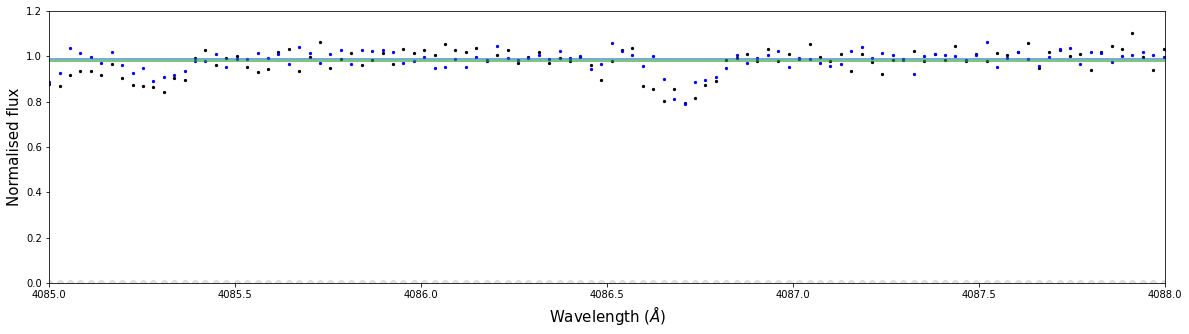

In [109]:
plt.figure(figsize=(20,5))

elems_to_include = ['Th 2']

# plt.step(sme.wave.data, sme.spec.data, lw=1, color='k', where='mid')
plt.scatter(sme.wave.data, sme.spec.data, s=5, color='k')
plt.scatter(sme2.wave.data, sme2.spec.data, s=5, color='b')
# plt.errorbar(sme.wave.data, sme.spec.data, fmt='k.', lw=1, yerr=sme.uncs.data, alpha=0.8)

#Al only
# x = sme.wave.data
# plt.plot(sme.wave.data, sme.spec.data/(sme.cscale[0][0]*(x-x[0])**2. + sme.cscale[0][1]*(x-x[0]) + sme.cscale[0][2]), lw=0.8, color='k')
# plt.plot(sme.wave.data, sme.synth.data/(sme.cscale[0][0]*(x-x[0])**2. + sme.cscale[0][1]*(x-x[0]) + sme.cscale[0][2]), lw=1.5, color='C2', alpha=0.8)

# synth_smooth = uniform_filter1d(sme.synth.data, size=50)
# plt.plot(sme.wave.data, synth_smooth, lw=1.5, color='C2', alpha=0.8)
plt.plot(sme.wave.data, sme.synth.data, lw=1.5, color='C2', alpha=0.8)
plt.plot(sme2.wave.data, sme2.synth.data, lw=1.5, color='C0', alpha=0.8)

plt.scatter(sme.wave.data, sme.mask.data, color='grey', alpha=0.2)
# plt.scatter(sme.wave.data[sme.mask.data == 2], sme.mask.data[sme.mask.data == 2] - 1, color='grey', alpha=0.2)

for wline, species in pd.DataFrame(sme.linelist)[['wlcent', 'species']].values:
    if 'H 1' in species:
        continue
    if (species == 'Fe 1') | (species == 'Fe 2'):
        plt.vlines(wline, 0.1, 0.15, color='r')
    if species not in elems_to_include:
        continue
#     # if (depth > 0.85) | (depth < 0.15):
#     #     continue
    
    plt.vlines(wline, 0.2, 0.25, color='C4')
    # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)
    

# plt.vlines(5167.3, 0, 1, )

# plt.xlim(4170, 4190) #Fe

# plt.xlim(4930, 4938) #Ba
# plt.xlim(5851, 5857) #Ba
# plt.xlim(6139, 6145) #Ba
# plt.xlim(6492, 6502) #Ba

# plt.xlim(4213, 4219) #Sr
# plt.xlim(4074, 4080) #Sr

plt.xlim(4128, 4132) #Eu
# plt.xlim(4202, 4208) #Eu

# plt.xlim(4390, 4402) #Ti
# plt.xlim(4430, 4470) #Ti
# plt.xlim(4980, 5020) #Ti

# plt.xlim(5474, 5480) #Ni
# plt.xlim(5077, 5083) #Ni
# plt.xlim(4398, 4404) #Ni

# plt.xlim(5165.5, 5185) #Mg

# plt.xlim(4222, 4232) #Ca
# plt.xlim(4433, 4458) #Ca
# plt.xlim(6438, 6463) #Ca

# plt.xlim(4175, 4180) #Y
# plt.xlim(4200, 4210) #Y
# plt.xlim(4230, 4240) #Y
# plt.xlim(4372, 4378) #Y
# plt.xlim(4880, 4905) #Y
# plt.xlim(5200, 5210) #Y
# plt.xlim(5084, 5091) #Y

# plt.xlim(4025, 4038) #La
# plt.xlim(4070, 4090) #La
# plt.xlim(4120, 4130) #La

# plt.xlim(4028, 4039) #Mn
# plt.xlim(4125, 4131) #Mn

# plt.xlim(5880, 5900) #Na

# plt.xlim(4085, 4100) #Co
# plt.xlim(4115, 4125) #Co

# plt.xlim(4235, 4260) #Cr
# plt.xlim(4343, 4355) #Cr
# plt.xlim(5200, 5215) #Cr
# plt.xlim(5342, 5354) #Cr

# plt.xlim(4000, 4005) #Dy
# plt.xlim(4070, 4080) #Dy
# plt.xlim(4126, 4132) #Dy
# plt.xlim(4954, 4960) #Dy
# plt.xlim(4100, 4106) #Dy
# plt.xlim(4072, 4079) #Dy

# plt.xlim(4010, 4015) #Nd
# plt.xlim(4105, 4114) #Nd
# plt.xlim(4154, 4159) #Nd
# plt.xlim(4176, 4180) #Nd
# plt.xlim(4245, 4255) #Nd

# plt.xlim(4010, 4020) #Sc
# plt.xlim(4235, 4260) #Sc
# plt.xlim(4370, 4420) #Sc
# plt.xlim(4395, 4405) #Sc
# plt.xlim(5025, 5040) #Sc
# plt.xlim(5235, 5245) #Sc
# plt.xlim(5525, 5532) #Sc

# plt.xlim(4100, 4106) #Si
# plt.xlim(4790, 4794) #Si
# plt.xlim(6345, 6349) #Si

# plt.xlim(4000, 4010) #V
# plt.xlim(4020, 4025) #V
# plt.xlim(4030, 4038) #V
# plt.xlim(4108, 4118) #V
# plt.xlim(4375, 4393) #V

# plt.xlim(4808, 4814) #Zn
# plt.xlim(6360, 6364) #Zn

# plt.xlim(4025, 4035) #Zr
# plt.xlim(4045, 4050) #Zr
# plt.xlim(4145, 4165) #Zr
# plt.xlim(4154, 4163) #Zr
# plt.xlim(4205, 4220) #Zr

# plt.xlim(6694, 6700) #Al
# plt.xlim(5555, 5559) #Al
# plt.xlim(6782, 6786) #Al
# plt.xlim(4874, 4878) #Al
# plt.xlim(3898, 3902) #Al
# plt.xlim(3959, 3963) #Al
# plt.xlim(3940, 3965) #Al

# plt.xlim(6702, 6715) #Li
# plt.xlim(6100, 6105) #Li

# plt.xlim(4365, 4371) #O
# plt.xlim(6150, 6160) #O
# plt.xlim(6296, 6305) #[O]
# plt.xlim(6299, 6302) #[O]
# plt.xlim(6360, 6366) #O

# plt.xlim(4040, 4050) #K

# plt.xlim(3858.5, 3861) #U

# plt.xlim(4185, 4190) #Mo
# plt.xlim(4408, 4414) #Mo
# plt.xlim(4064, 4073) #Mo
# plt.xlim(4378, 4385) #Mo

# plt.xlim(4134, 4141) #Ce
# plt.xlim(4182, 4192) #Ce
# plt.xlim(4060, 4070) #Ce

plt.xlim(4016,4022) #Th
plt.xlim(4085,4088) #Th

# plt.xlim(4176, 4182) #Pr
# plt.xlim(4140, 4146) #Pr
# plt.xlim(4220, 4224) #Pr
# plt.xlim(4405, 4411) #Pr
# plt.xlim(4060, 4064) #Pr

# plt.xlim(4096, 4100) #Gd
# plt.xlim(4046, 4052) #Gd
# plt.xlim(4182, 4187) #Gd

# plt.xlim(4216, 4223)
plt.ylim(0.0, 1.2)

# plt.plot(tell['waveobs']*10.+4.63, tell['flux'], color='C4', lw=2, alpha=0.5)

plt.xlabel(r'Wavelength ($\AA$)', size=15)
plt.ylabel(r'Normalised flux', size=15)
# plt.xlim(6500, 6600)
# plt.savefig('plots/CEMP.pdf')
plt.show()

In [98]:
sme.fitresults.values

array([-3.2291637])

In [217]:
solar.abund.get_element('O')

8.69

In [160]:
tell = ispec.read_spectrum('/home/fgran/iSpec/input/spectra/templates/Synth.Tellurics.350_1100nm/template.txt.gz')
tel_wl_min_rv, tel_wl_max_rv = 629.5, 630.5
tel_wl_min, tel_wl_max = 629.5, 630.5
tell = tell[ispec.create_wavelength_filter(tell, wave_base=tel_wl_min_rv, wave_top=tel_wl_max_rv)]

In [112]:
sme.cscale

array([[0.98798387],
       [0.99338016],
       [0.99597077]])

In [113]:
sme.monh

-2.458182643272437

In [114]:
sme.fitresults.values, sme.fitresults.uncertainties, sme.fitresults.fit_uncertainties, sme.monh, sme.vmac

(array([1.57861741]),
 array([0.17345465]),
 [0.06074850098660041],
 -2.458182643272437,
 6.063275313248981)

In [34]:
sme.fitresults.iterations

6

In [115]:
sme.vrad

array([-0.55842495, -4.82893477, -3.98147372])

In [74]:
sme.vrad

array([0.18302592, 0.        , 0.        ])

In [141]:
uves_fe.sort_values(by='monh', ascending=True).spec_id

7      2541284393302759296_3708442_129
62     4854289415101796608_3708430_135
103    6488378098744387968_3576337_082
70     5735381717990313216_3572855_004
38     3572437218517370240_3573679_095
                    ...               
35     3543785319887452800_3572787_023
133    6728409939582968192_3572831_014
110    6631364397619544448_3572790_006
64     4905666294932720000_3708505_125
41     3608416056475856512_3708499_157
Name: spec_id, Length: 160, dtype: object

In [26]:
#Merging files with abundances

In [41]:
%%time
#Merge all files into one

# os.system('cat tmp_elems/elem_fe_???????????????????_???????_???.csv > tmp_merged/elem_fe_merged.csv');
# os.system('cat tmp_elems/elem_fe_nlte*.csv > tmp_merged/elem_fe_nlte_merged.csv');
os.system('cat tmp_elems/elem_ba_???????????????????_???????_???.csv > tmp_merged/elem_ba_merged.csv');
os.system('cat tmp_elems/elem_ba_nlte*.csv > tmp_merged/elem_ba_nlte_merged.csv');
os.system('cat tmp_elems/elem_sr*.csv > tmp_merged/elem_sr_merged.csv');
os.system('cat tmp_elems/elem_eu*.csv > tmp_merged/elem_eu_merged.csv');
# os.system('cat tmp_elems/elem_ti_???????????????????_???????_???.csv > tmp_merged/elem_ti_merged.csv');
# os.system('cat tmp_elems/elem_ti_nlte*.csv > tmp_merged/elem_ti_nlte_merged.csv');
# os.system('cat tmp_elems/elem_ni*.csv > tmp_merged/elem_ni_merged.csv');
# os.system('cat tmp_elems/elem_mg_???????????????????_???????_???.csv > tmp_merged/elem_mg_merged.csv');
# os.system('cat tmp_elems/elem_mg_nlte*.csv > tmp_merged/elem_mg_nlte_merged.csv');
# os.system('cat tmp_elems/elem_ca_???????????????????_???????_???.csv > tmp_merged/elem_ca_merged.csv');
# os.system('cat tmp_elems/elem_ca_nlte*.csv > tmp_merged/elem_ca_nlte_merged.csv');
# os.system('cat tmp_elems/elem_y*.csv  > tmp_merged/elem_y_merged.csv');
# os.system('cat tmp_elems/elem_la*.csv > tmp_merged/elem_la_merged.csv');
# os.system('cat tmp_elems/elem_mn*.csv > tmp_merged/elem_mn_merged.csv');
# os.system('cat tmp_elems/elem_na*.csv > tmp_merged/elem_na_merged.csv');
# os.system('cat tmp_elems/elem_co*.csv > tmp_merged/elem_co_merged.csv');
# os.system('cat tmp_elems/elem_cr*.csv > tmp_merged/elem_cr_merged.csv');
# os.system('cat tmp_elems/elem_dy*.csv > tmp_merged/elem_dy_merged.csv');
# os.system('cat tmp_elems/elem_nd*.csv > tmp_merged/elem_nd_merged.csv');
# os.system('cat tmp_elems/elem_sc*.csv > tmp_merged/elem_sc_merged.csv');
# os.system('cat tmp_elems/elem_si_???????????????????_???????_???.csv > tmp_merged/elem_si_merged.csv');
# os.system('cat tmp_elems/elem_si_nlte*.csv > tmp_merged/elem_si_nlte_merged.csv');
# os.system('cat tmp_elems/elem_v*.csv  > tmp_merged/elem_v_merged.csv');
# os.system('cat tmp_elems/elem_zn*.csv > tmp_merged/elem_zn_merged.csv');
# os.system('cat tmp_elems/elem_zr*.csv > tmp_merged/elem_zr_merged.csv');
# os.system('cat tmp_elems/elem_li*.csv > tmp_merged/elem_li_merged.csv');
# os.system('cat tmp_elems/elem_al*.csv > tmp_merged/elem_al_merged.csv');
# os.system('cat tmp_elems/elem_k*.csv > tmp_merged/elem_k_merged.csv');
# os.system('cat tmp_elems/elem_o*.csv > tmp_merged/elem_o_merged.csv');
# os.system('cat tmp_elems/elem_mo*.csv > tmp_merged/elem_mo_merged.csv');
# os.system('cat tmp_elems/elem_ce*.csv > tmp_merged/elem_ce_merged.csv');
# os.system('cat tmp_elems/elem_u*.csv > tmp_merged/elem_u_merged.csv');
# os.system('cat tmp_elems/elem_th*.csv > tmp_merged/elem_th_merged.csv');
# os.system('cat tmp_elems/elem_pr*.csv > tmp_merged/elem_pr_merged.csv');
# os.system('cat tmp_elems/elem_gd*.csv > tmp_merged/elem_gd_merged.csv');

# os.system("sed '1i spec_id,fe,efe_sme,efe_fit,sme_vrad1,sme_vrad2,sme_vrad3,vmac' tmp_merged/elem_fe_merged.csv -i ");
# os.system("sed '1i spec_id,fe_nlte,efe_nlte_sme,efe_nlte_fit,sme_vrad1,sme_vrad2,sme_vrad3,vmac' tmp_merged/elem_fe_nlte_merged.csv -i ");
os.system("sed '1i spec_id,ba,eba_sme,eba_fit,niter_ba' tmp_merged/elem_ba_merged.csv -i ");
os.system("sed '1i spec_id,ba_nlte,eba_nlte_sme,eba_nlte_fit,niter_ba_nlte' tmp_merged/elem_ba_nlte_merged.csv -i ");
os.system("sed '1i spec_id,sr,esr_sme,esr_fit,niter_sr' tmp_merged/elem_sr_merged.csv -i ");
os.system("sed '1i spec_id,eu,eeu_sme,eeu_fit,niter_eu' tmp_merged/elem_eu_merged.csv -i ");
# os.system("sed '1i spec_id,ti,eti_sme,eti_fit,niter_ti' tmp_merged/elem_ti_merged.csv -i ");
# os.system("sed '1i spec_id,ti_nlte,eti_nlte_sme,eti_nlte_fit,niter_ti_nlte' tmp_merged/elem_ti_nlte_merged.csv -i ");
# os.system("sed '1i spec_id,ni,eni_sme,eni_fit' tmp_merged/elem_ni_merged.csv -i ");
# os.system("sed '1i spec_id,mg,emg_sme,emg_fit,niter_mg' tmp_merged/elem_mg_merged.csv -i ");
# os.system("sed '1i spec_id,mg_nlte,emg_nlte_sme,emg_nlte_fit,niter_mg_nlte' tmp_merged/elem_mg_nlte_merged.csv -i ");
# os.system("sed '1i spec_id,ca,eca_sme,eca_fit,niter_ca' tmp_merged/elem_ca_merged.csv -i ");
# os.system("sed '1i spec_id,ca_nlte,eca_nlte_sme,eca_nlte_fit,niter_ca_nlte' tmp_merged/elem_ca_nlte_merged.csv -i ");
# os.system("sed '1i spec_id,y,ey_sme,ey_fit,niter_y' tmp_merged/elem_y_merged.csv -i ");
# os.system("sed '1i spec_id,la,ela_sme,ela_fit,niter_la' tmp_merged/elem_la_merged.csv -i ");
# os.system("sed '1i spec_id,mn,emn_sme,emn_fit' tmp_merged/elem_mn_merged.csv -i ");
# os.system("sed '1i spec_id,na,ena_sme,ena_fit' tmp_merged/elem_na_merged.csv -i ");
# os.system("sed '1i spec_id,co,eco_sme,eco_fit' tmp_merged/elem_co_merged.csv -i ");
# os.system("sed '1i spec_id,cr,ecr_sme,ecr_fit' tmp_merged/elem_cr_merged.csv -i ");
# os.system("sed '1i spec_id,dy,edy_sme,edy_fit,niter_dy' tmp_merged/elem_dy_merged.csv -i ");
# os.system("sed '1i spec_id,nd,end_sme,end_fit,niter_nd' tmp_merged/elem_nd_merged.csv -i ");
# os.system("sed '1i spec_id,sc,esc_sme,esc_fit' tmp_merged/elem_sc_merged.csv -i ");
# os.system("sed '1i spec_id,si_nlte,esi_nlte_sme,esi_nlte_fit,niter_si_nlte' tmp_merged/elem_si_nlte_merged.csv -i ");
# os.system("sed '1i spec_id,si,esi_sme,esi_fit,niter_si' tmp_merged/elem_si_merged.csv -i ");
# os.system("sed '1i spec_id,v,ev_sme,ev_fit' tmp_merged/elem_v_merged.csv -i ");
# os.system("sed '1i spec_id,zn,ezn_sme,ezn_fit' tmp_merged/elem_zn_merged.csv -i ");
# os.system("sed '1i spec_id,zr,ezr_sme,ezr_fit' tmp_merged/elem_zr_merged.csv -i ");
# os.system("sed '1i spec_id,li,eli_sme,eli_fit,niter_li' tmp_merged/elem_li_merged.csv -i ");
# os.system("sed '1i spec_id,al,eal_sme,eal_fit' tmp_merged/elem_al_merged.csv -i ");
# os.system("sed '1i spec_id,k,ek_sme,ek_fit' tmp_merged/elem_k_merged.csv -i ");
# os.system("sed '1i spec_id,o,eo_sme,eo_fit' tmp_merged/elem_o_merged.csv -i ");
# os.system("sed '1i spec_id,mo,emo_sme,emo_fit' tmp_merged/elem_mo_merged.csv -i ");
# os.system("sed '1i spec_id,ce,ece_sme,ece_fit' tmp_merged/elem_ce_merged.csv -i ");
# os.system("sed '1i spec_id,u,eu_sme,eu_fit' tmp_merged/elem_u_merged.csv -i ");
# os.system("sed '1i spec_id,th,eth_sme,eth_fit' tmp_merged/elem_th_merged.csv -i ");
# os.system("sed '1i spec_id,pr,epr_sme,epr_fit' tmp_merged/elem_pr_merged.csv -i ");
# os.system("sed '1i spec_id,gd,egd_sme,egd_fit' tmp_merged/elem_gd_merged.csv -i ");

# spec_id,fe,efe_sme,efe_fit,sme_vrad1,sme_vrad2,sme_vrad3
# spec_id,ba,eba_sme,eba_fit
# spec_id,sr,esr_sme,esr_fit
# spec_id,eu,eeu_sme,eeu_fit
# spec_id,ti,eti_sme,eti_fit
# spec_id,ni,eni_sme,eni_fit
# spec_id,mg,emg_sme,emg_fit
# spec_id,ca,eca_sme,eca_fit
# spec_id,y,ey_sme,ey_fit
# spec_id,la,ela_sme,ela_fit
# spec_id,mn,emn_sme,emn_fit
# spec_id,na,ena_sme,ena_fit
# spec_id,co,eco_sme,eco_fit
# spec_id,cr,ecr_sme,ecr_fit
# spec_id,dy,edy_sme,edy_fit
# spec_id,nd,end_sme,end_fit
# spec_id,sc,esc_sme,esc_fit
# spec_id,si,esi_sme,esi_fit
# spec_id,v,ev_sme,ev_fit
# spec_id,zn,ezn_sme,ezn_fit
# spec_id,zr,ezr_sme,ezr_fit
# spec_id,li,eli_sme,eli_fit
# spec_id,al,eal_sme,eal_fit
# spec_id,k,ek_sme,ek_fit
# spec_id,o,eo_sme,eo_fit
# spec_id,mo,emo_sme,emo_fit
# spec_id,ce,ece_sme,ece_fit
# spec_id,u,eu_sme,eu_fit
# spec_id,th,eth_sme,eth_fit
# spec_id,pr,epr_sme,epr_fit
# spec_id,gd,egd_sme,egd_fit

CPU times: user 0 ns, sys: 37.5 ms, total: 37.5 ms
Wall time: 11.9 s


0

In [45]:
#Merge all files

In [46]:
solar = SME_Structure()
solar.abund = Abund(0.0, 'asplund2009')

In [47]:
elems_x_merged = sorted(glob.glob('tmp_merged/elem_*_merged.csv'))

In [48]:
uves = pd.read_csv('uves_p111_p112_pristinedr1_xgboost_atm_means_carbon_nitrogen_limits.csv')
uves.drop(columns=['sme_vrad1', 'sme_vrad2', 'sme_vrad3', 'vmac'], inplace=True)

elems_x_merged = sorted(glob.glob('tmp_merged/elem_*_merged.csv'))

for elem_x_merged in elems_x_merged:
    elem_x = pd.read_csv(elem_x_merged)
    if elem_x_merged == 'tmp_merged/elem_fe_merged.csv':
        elem_x.drop(columns=['sme_vrad1', 'sme_vrad2', 'sme_vrad3', 'vmac'], inplace=True)
    uves = uves.merge(right=elem_x, right_on='spec_id', left_on='spec_id')
    # print(elem_x.columns, uves.ra.size)
    
uves['feh'] = uves.fe.values - solar.abund.get_element('Fe') + uves.monh.values
uves['feh_nlte'] = uves.fe_nlte.values - solar.abund.get_element('Fe') + uves.monh.values
uves['bafe'] = uves.ba.values - solar.abund.get_element('Ba')
uves['bafe_nlte'] = uves.ba_nlte.values - solar.abund.get_element('Ba')
uves['srfe'] = uves.sr.values - solar.abund.get_element('Sr')
uves['eufe'] = uves.eu.values - solar.abund.get_element('Eu')
uves['tife'] = uves.ti.values - solar.abund.get_element('Ti')
uves['tife_nlte'] = uves.ti_nlte.values - solar.abund.get_element('Ti')
uves['nife'] = uves.ni.values - solar.abund.get_element('Ni')
uves['mgfe'] = uves.mg.values - solar.abund.get_element('Mg')
uves['mgfe_nlte'] = uves.mg_nlte.values - solar.abund.get_element('Mg')
uves['cafe'] = uves.ca.values - solar.abund.get_element('Ca')
uves['cafe_nlte'] = uves.ca_nlte.values - solar.abund.get_element('Ca')
uves['yfe'] = uves.y.values - solar.abund.get_element('Y')
uves['lafe'] = uves.la.values - solar.abund.get_element('La')
uves['mnfe'] = uves.mn.values - solar.abund.get_element('Mn')
uves['nafe'] = uves.na.values - solar.abund.get_element('Na')
uves['cofe'] = uves.co.values - solar.abund.get_element('Co')
uves['crfe'] = uves.cr.values - solar.abund.get_element('Cr')
uves['dyfe'] = uves.dy.values - solar.abund.get_element('Dy')
uves['ndfe'] = uves.nd.values - solar.abund.get_element('Nd')
uves['scfe'] = uves.sc.values - solar.abund.get_element('Sc')
uves['sife'] = uves.si.values - solar.abund.get_element('Si')
uves['sife_nlte'] = uves.si_nlte.values - solar.abund.get_element('Si')
uves['vfe'] = uves.v.values - solar.abund.get_element('V')
uves['znfe'] = uves.zn.values - solar.abund.get_element('Zn')
uves['zrfe'] = uves.zr.values - solar.abund.get_element('Zr')
uves['life'] = uves.li.values - solar.abund.get_element('Li')
uves['alfe'] = uves.al.values - solar.abund.get_element('Al')
uves['kfe'] = uves.k.values - solar.abund.get_element('K')
uves['ofe'] = uves.o.values - solar.abund.get_element('O')
uves['mofe'] = uves.mo.values - solar.abund.get_element('Mo')
uves['cefe'] = uves.ce.values - solar.abund.get_element('Ce')
# uves['ufe'] = uves.u.values - solar.abund.get_element('U')
uves['thfe'] = uves.th.values - solar.abund.get_element('Th')
uves['prfe'] = uves.pr.values - solar.abund.get_element('Pr')
uves['gdfe'] = uves.gd.values - solar.abund.get_element('Gd')

In [49]:
uves.to_csv('uves_p111_p112_pristinedr1_xgboost_atm_means_carbon_nitrogen_limits_all_elems.csv', index=False, header=True)

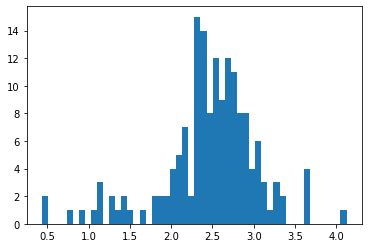

In [65]:
plt.hist(uves.sr.values, bins=50)
plt.show()

In [20]:
# REference De la Reza in brasil papers to look for 

In [219]:
# uves[uves.eli_sme < li_err].sort_values(by='li', ascending=False).spec_id

NameError: name 'jina' is not defined

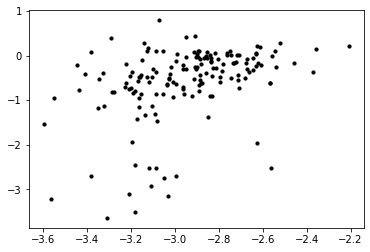

In [55]:
plt.scatter(uves.feh.values, uves.bafe.values, s=10, color='k')
# plt.scatter(jina.feh.values, jina.bafe.values, color='grey', s=1, alpha=0.25)
plt.xlim(-3.7, -2.2)
plt.ylim(-2.5, 2.0)
plt.show()

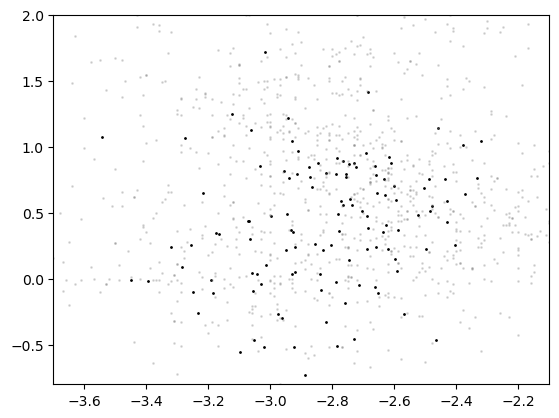

In [327]:
plt.scatter(uves.feh.values, uves.eufe.values, s=1, color='k')
plt.scatter(jina.feh.values, jina.eufe.values, color='grey', s=1, alpha=0.25)
plt.xlim(-3.7, -2.1)
plt.ylim(-0.8, 2.)
plt.show()

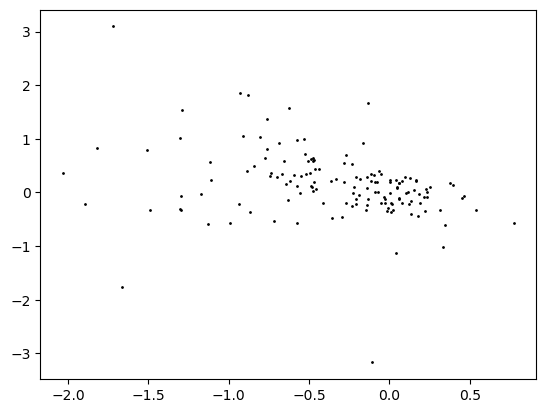

In [309]:
plt.scatter(uves.bafe.values, uves.srfe.values - uves.bafe.values, s=1, color='k')
# plt.ylim(-0.8, 2.)
plt.show()

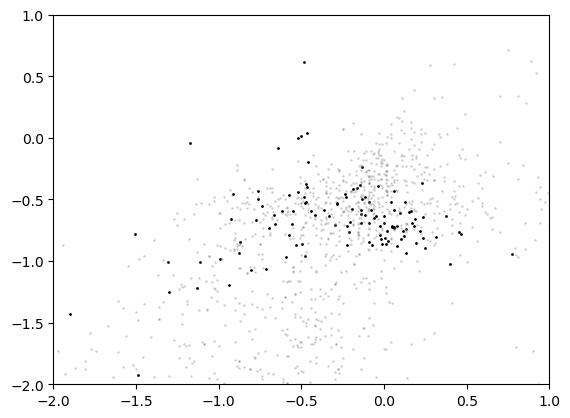

In [334]:
plt.scatter(uves.bafe.values, uves.bafe.values - uves.eufe.values, s=1, color='k')
plt.scatter(jina.bafe.values, jina.bafe.values - jina.eufe.values, color='grey', s=1, alpha=0.25)

plt.xlim(-2.0, 1.)
plt.ylim(-2.0, 1.)
plt.show()

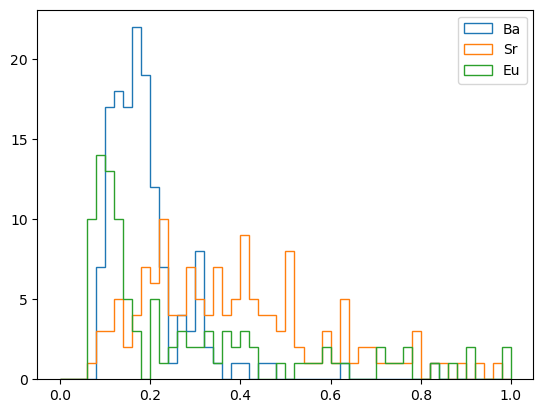

In [258]:
# plt.hist(uves_fe0.efe_sme.values, bins=25, histtype='step')
# plt.hist(uves_fe_sr.sr.values, bins=25, histtype='step')
# plt.hist(uves_fe_eu.eu.values, bins=25, histtype='step')

plt.hist(uves.eba_sme.values, bins=50, histtype='step', range=(0, 1.), label='Ba')
plt.hist(uves.esr_sme.values, bins=50, histtype='step', range=(0, 1.), label='Sr')
plt.hist(uves.eeu_sme.values, bins=50, histtype='step', range=(0, 1.), label='Eu')

# plt.hist(uves_fe_ba.ba.values - solar.abund.get_element('Ba'), bins=50, histtype='step', density=True)
# plt.hist(jina.bafe.values, bins=100, density=True)

# plt.xlim(-2,1)
plt.legend()
plt.show()

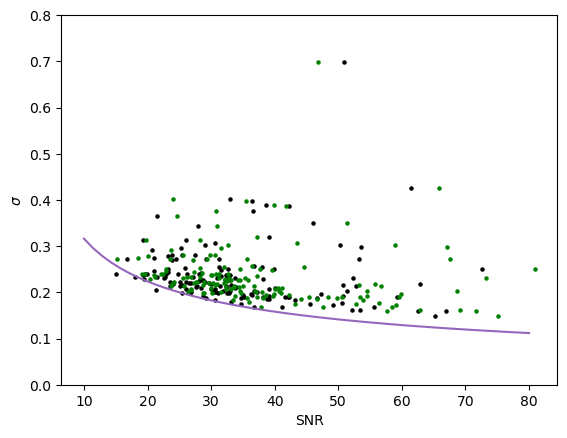

In [286]:
plt.scatter(uves.snr_4030.values, uves.efe_sme.values, s=5, color='k')
plt.scatter(uves.snr_4460.values, uves.efe_sme.values, s=5, color='g')

x = np.linspace(10, 80)
plt.plot(x, 1./x**0.5, color='C4')

plt.xlabel('SNR')
plt.ylabel(r'$\sigma$')
plt.ylim(0.0, 0.8)
plt.show()

In [24]:
#NLTE grids

# sme.nlte.set_nlte('Fe', 'nlte_Fe_ama51_Feb2022_pysme.grd')
# sme.nlte.set_nlte('Mg', 'nlte_Mg_ama51_pysme.grd')
# sme.nlte.set_nlte('Ba', 'nlte_Ba_ama51_pysme.grd')
# sme.nlte.set_nlte('Ca', 'nlte_Ca_ama51_pysme.grd')
# sme.nlte.set_nlte('H', 'nlte_H_ama51_pysme.grd')
# sme.nlte.set_nlte('C', 'nlte_C_ama51_pysme.grd')
# sme.nlte.set_nlte('N', 'nlte_N_ama51_pysme.grd')
# sme.nlte.set_nlte('Al', 'nlte_Al_ama51_pysme.grd')
# sme.nlte.set_nlte('Li', 'nlte_Li_ama51_pysme.grd')
# sme.nlte.set_nlte('Na', 'nlte_Na_ama51_pysme.grd')
# sme.nlte.set_nlte('Ti', 'marcs2012s_t2.0_Ti.grd')
# sme.nlte.set_nlte('K', 'nlte_K_ama51_pysme.grd')
# sme.nlte.set_nlte('Mn', 'nlte_Mn_ama51_pysme.grd')    
# sme.nlte.set_nlte('Si', 'nlte_Si_ama51_pysme.grd')
# sme.nlte.set_nlte('O', 'nlte_O_ama51_pysme.grd')